# RAP Model Sounding Profile 1900 UTC 19 June 2025

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import h5py
from six import StringIO

'''
RAP Model Profile at 1900 UTC 19 June 2025 
'''
 
def read_RAP_plot(ncf):
    nc_fid = Dataset(ncf, 'r')
    cape = nc_fid.variables["Convective_available_potential_energy_surface"][:]
    height = nc_fid.variables["Geopotential_height_isobaric"][:]  # shape lat, lon as shown above
    press = nc_fid.variables["isobaric"][:]
    temp = nc_fid.variables["Temperature_isobaric"][:]
    RH = nc_fid.variables["Relative_humidity_isobaric"][:]
    SM_U = nc_fid.variables["U-Component_Storm_Motion_height_above_ground_layer"][:]
    SM_V = nc_fid.variables["U-Component_Storm_Motion_height_above_ground_layer"][:]
    lats = nc_fid.variables['lat'][:]  # extract/copy the data
    lons = nc_fid.variables['lon'][:]
    names = nc_fid.variables.keys()
    nc_fid.close()
    return cape, height, press, temp, RH, SM_U, SM_V, lats, lons, names

RAP_ret_file = '20250619_rap_130_20250619_1800_001.nc'

cape, height, press, temp, RH, SM_U, SM_V, lats, lons, names = read_RAP_plot(RAP_ret_file)
print(names)

print("CAPE: ",cape,cape.shape)
print("Pressure: ",press,press.shape)
press_mb = press/100
print("Pressure mb: ",press_mb,press_mb.shape)
print("Height: ",height,height.shape)
height_km = height/1000
print("Height km: ",height_km,height_km.shape)
print("Temperature: ",temp,temp.shape)
print("Humidity: ", RH, RH.shape)
SM_u = SM_U[0,0,:,:]
print("Storm Motion U: ",SM_u,SM_u.shape)
SM_v = SM_V[0,0,:,:]
print("Storm Motion V: ",SM_v,SM_v.shape)
print("Latitude: ",lats,lats.shape)
print("Longitude: ",lons,lons.shape)

def generate_magnitude_array(x_components_2d, y_components_2d):
    """
    Generates a 2-dimensional array (list of lists) of velocity magnitudes
    from corresponding 2-dimensional arrays of x and y components.

    Args:
        x_components_2d (list of lists of float or int): A 2D array where
                                                         each element is an
                                                         x-component of a velocity.
        y_components_2d (list of lists of float or int): A 2D array where
                                                         each element is a
                                                         y-component of a velocity.

    Returns:
        list of lists of float: A 2D array where each element is the
                                magnitude of the corresponding velocity vector.

    Raises:
        ValueError: If the input arrays do not have the same dimensions.
    """
    # Get the dimensions of the input arrays
    num_rows_x = len(x_components_2d)
    if num_rows_x == 0:
        return [] # Handle empty input gracefully

    num_cols_x = len(x_components_2d[0])

    num_rows_y = len(y_components_2d)
    if num_rows_y == 0:
        raise ValueError("y_components_2d cannot be empty if x_components_2d is not.")

    num_cols_y = len(y_components_2d[0])

    # Check if the dimensions match
    if num_rows_x != num_rows_y or num_cols_x != num_cols_y:
        raise ValueError("Input arrays for x and y components must have the same dimensions.")

    # Initialize an empty 2D array to store the magnitudes
    magnitudes_2d = []

    # Iterate through the rows
    for r in range(num_rows_x):
        current_row_magnitudes = []
        # Iterate through the columns
        for c in range(num_cols_x):
            x = x_components_2d[r][c]
            y = y_components_2d[r][c]

            # Calculate the magnitude using the Pythagorean theorem: sqrt(x^2 + y^2)
            magnitude = math.sqrt(x**2 + y**2)
            current_row_magnitudes.append(magnitude)
        magnitudes_2d.append(current_row_magnitudes)

    return magnitudes_2d

# Generate the 2D array of magnitudes
SM_mag_list = generate_magnitude_array(SM_u, SM_v)

print("\nCalculated Velocity Magnitudes:")
for row in SM_mag_list:
    print([f"{val:.2f}" for val in row]) # Format for better readability

def list_to_array_2d(list_2d):
  """
  Converts a 2-D Python list into a 2-D NumPy array.

  Args:
    list_2d: A list of lists (2-D list).

  Returns:
    A 2-D NumPy array.
  """
  return np.array(list_2d)

SM_mag = list_to_array_2d(SM_mag_list)
print("Storm Motion: ",SM_mag,SM_mag.shape)
temperature_c = temp - 273.15
temp_800 = temp[0,28,:,:]
temp_950 = temp[0,34,:,:]
temperature_c_800 = temperature_c[0,28,:,:]
temperature_c_850 = temperature_c[0,30,:,:]
temperature_c_950 = temperature_c[0,34,:,:]
RH_800 = RH[0,28,:,:]
RH_850 = RH[0,30,:,:]
RH_950 = RH[0,34,:,:]
press_800 = press_mb[28]
press_850 = press_mb[30]
press_950 = press_mb[34]
dewpoint_c_800 = 243.04*((np.log(RH_800/100))+((17.625*temperature_c_800)/(243.04+temperature_c_800)))/(17.625-(np.log(RH_800/100))-((17.625*temperature_c_800)/(243.04+temperature_c_800)))
print("Dewpoint 800 mb (C): ",dewpoint_c_800,dewpoint_c_800.shape)
dewpoint_c_950 = 243.04*((np.log(RH_950/100))+((17.625*temperature_c_950)/(243.04+temperature_c_950)))/(17.625-(np.log(RH_950/100))-((17.625*temperature_c_950)/(243.04+temperature_c_950)))
print("Dewpoint 950 mb (C): ",dewpoint_c_950,dewpoint_c_950.shape)
height_km_800 = height_km[0,28,:,:]
height_km_950 = height_km[0,34,:,:]
cape_2D = cape[0,:,:]

L_vapor = 2500
thetae_800 = (273.15 + temperature_c_800)*((1000/press_800)**0.286)+(3 * (RH_800 * (3.884266 * 10**
         ((7.5 * temperature_c_800)/(237.7 + temperature_c_800)))/100))
print("Theta-e 800 mb: ", thetae_800, thetae_800.shape)
thetae_850 = (273.15 + temperature_c_850)*((1000/press_850)**0.286)+(3 * (RH_850 * (3.884266 * 10**
         ((7.5 * temperature_c_850)/(237.7 + temperature_c_850)))/100))
print("Theta-e 850 mb: ", thetae_850, thetae_850.shape)
thetae_950 = (273.15 + temperature_c_850)*((1000/press_850)**0.286)+(3 * (RH_850 * (3.884266 * 10**
         ((7.5 * temperature_c_850)/(237.7 + temperature_c_850)))/100))
print("Theta-e 950 mb: ", thetae_950, thetae_950.shape)
wetbulb_800 = temperature_c_800*(np.arctan(0.151977*((RH_800+8.313659)**0.5))) + (np.arctan(temperature_c_800+RH_800)) - (np.arctan(RH_800-1.676331))+((0.00391838*(RH_800**1.5))*(np.arctan(0.023101*RH_800))) - 4.686035
print("Wet bulb 800 mb: ", wetbulb_800, wetbulb_800.shape)
wetbulb_950 = temperature_c_950*(np.arctan(0.151977*((RH_950+8.313659)**0.5))) + (np.arctan(temperature_c_950+RH_950)) - (np.arctan(RH_950-1.676331))+((0.00391838*(RH_950**1.5))*(np.arctan(0.023101*RH_950))) - 4.686035
print("Wet bulb 950 mb: ", wetbulb_950, wetbulb_950.shape)
mixrat_800 = (6.11*(10**((7.5*dewpoint_c_800)/(237.7+dewpoint_c_800))))/1000
print("Mix_ratio 800 mb = ",mixrat_800)
mixrat_950 = (6.11*(10**((7.5*dewpoint_c_950)/(237.7+dewpoint_c_800))))/1000
print("Mix_ratio 950 mb = ",mixrat_950)
tempvirt_800 = temp_800*(1+(0.61*(mixrat_800)))
tempvirt_c_800 = tempvirt_800 - 273.15
print("Virtual Temperature (C) 800 mb = ",tempvirt_c_800)
tempvirt_950 = temp_950*(1+(0.61*(mixrat_950)))
tempvirt_c_950 = tempvirt_950 - 273.15
print("Virtual Temperature (C) 950 mb = ",tempvirt_c_950)

temp_prof_k = temp[0,:,31,20] 
temp_prof_fdk = temperature_c[0,:,31,20]
print("Temperature profile FDK: ",temp_prof_fdk,temp_prof_fdk.shape)
RH_fdk = RH[0,:,31,20]
dewpt_prof_fdk = 243.04*((np.log(RH_fdk/100))+((17.625*temp_prof_fdk)/(243.04+temp_prof_fdk)))/(17.625-(np.log(RH_fdk/100))-((17.625*temp_prof_fdk)/(243.04+temp_prof_fdk)))
print("Dewpoint profile FDK: ",dewpt_prof_fdk,dewpt_prof_fdk.shape)
cape_fdk = cape[0,31,20]
print("CAPE at FDK: ",cape_fdk,cape_fdk.shape)
lat_sdg = lats[31,20]
print("Sounding latitude: ",lat_sdg,lat_sdg.shape)
lon_sdg = lons[31,20]
print("Sounding longitude: ",lon_sdg,lon_sdg.shape)
height_prof_fdk = height[0,:,31,20]
print("Height profile FDK: ",height_prof_fdk,height_prof_fdk.shape)
height_km_prof_fdk = height_prof_fdk/1000
print("Height profile km FDK: ",height_km_prof_fdk,height_km_prof_fdk.shape)
mixrat_fdk = (6.11*(10**((7.5*dewpt_prof_fdk)/(237.7+dewpt_prof_fdk))))/1000
print("Mix_ratio FDK = ",mixrat_fdk)
thetae_prof_fdk = (273.15 + temp_prof_fdk)*((1000/press_mb)**0.286)+(3 * (RH_fdk * (3.884266 * 10**
         ((7.5 * temp_prof_fdk)/(237.7 + temp_prof_fdk)))/100))
print("Theta-e profile FDK: ",thetae_prof_fdk,thetae_prof_fdk.shape)
thetaw_prof_fdk = thetae_prof_fdk - (L_vapor*mixrat_fdk)
print("Theta-w profile FDK: ",thetaw_prof_fdk,thetaw_prof_fdk.shape)
wetbulb_prof_fdk = temp_prof_fdk*(np.arctan(0.151977*((RH_fdk+8.313659)**0.5))) + (np.arctan(temp_prof_fdk+RH_fdk)) - (np.arctan(RH_fdk-1.676331))+((0.00391838*(RH_fdk**1.5))*(np.arctan(0.023101*RH_fdk))) - 4.686035
print("Wetbulb temperature profile FDK: ",wetbulb_prof_fdk,wetbulb_prof_fdk.shape)
wbd_prof_fdk = temp_prof_fdk - wetbulb_prof_fdk
print("Wetbulb depression profile FDK: ",wbd_prof_fdk,wbd_prof_fdk.shape)
tempvirt_c_prof_fdk = (temp_prof_k*(1+(0.61*(mixrat_fdk))))- 273.15
print("Virtual temperature profile FDK: ",tempvirt_c_prof_fdk,tempvirt_c_prof_fdk.shape)
tempvirt_exc_prof_fdk = tempvirt_c_prof_fdk - temp_prof_fdk
print("Virtual temperature correction profile FDK: ",tempvirt_exc_prof_fdk,tempvirt_exc_prof_fdk.shape)

idx_pup = np.where(press == 80000.0)
idx_plo = np.where(press == 95000.0)
print("PUP idx = ", idx_pup)
print("PLO idx = ", idx_plo)
Z_upper = height_km_prof_fdk[idx_pup]
Z_lower = height_km_prof_fdk[idx_plo]
T_sfc = temp_prof_fdk[idx_plo]
T_top = temp_prof_fdk[idx_pup]
Te_sfc = thetae_prof_fdk[idx_plo]
Te_top = thetae_prof_fdk[idx_pup]
Tv_sfc = tempvirt_c_prof_fdk[idx_plo]
Tv_top = tempvirt_c_prof_fdk[idx_pup]
wetbulb_sfc = wetbulb_prof_fdk[idx_plo]
wetbulb_top = wetbulb_prof_fdk[idx_pup]
delta_z = Z_upper - Z_lower
gamma = (T_sfc - T_top)/(delta_z)
gamma_Te = (Te_sfc - Te_top)/(Z_lower - Z_upper)
gamma_Tv = (Tv_sfc - Tv_top)/(delta_z)
gamma_wb = (wetbulb_sfc - wetbulb_top)/(delta_z)

print("")
print("Gamma = ", gamma)
if gamma > 4.8 and gamma <= 9.8:
    print("Conditional Instability") 
elif gamma > 9.8:
    print("Absolute Instability")
print("Theta-e Gamma = ", gamma_Te)
if gamma_Te < 0:
    print("Theta-e lapse rate is negative: potential instability")    
print("Tv Gamma = ", gamma_Tv)
print("Wetbulb Gamma = ", gamma_wb)
if gamma_wb > 4.8:
    print("Potential Instability")    

def reverse_with_slicing(arr):
    """
    Reverses an array by using extended slice syntax.
    This creates a new, reversed copy of the array and does not modify the original.
    It's a concise and very common Python idiom.

    Args:
        arr: The input list/array.

    Returns:
        A new list containing the elements of the input list in reverse order.
    """
    print("--- Method 1: Reversing with Slicing [::] ---")
    print(f"Original array: {arr}")
    reversed_arr = arr[::-1]
    print(f"Reversed array (new copy): {reversed_arr}")
    print(f"Original array remains unchanged: {arr}")
    return reversed_arr

height_prof_fdk = reverse_with_slicing(height_prof_fdk)
height_km_prof_fdk = reverse_with_slicing(height_km_prof_fdk)
press_mb = reverse_with_slicing(press_mb)
temp_prof_fdk = reverse_with_slicing(temp_prof_fdk)
dewpt_prof_fdk = reverse_with_slicing(dewpt_prof_fdk)
thetae_prof_fdk = reverse_with_slicing(thetae_prof_fdk)
thetaw_prof_fdk = reverse_with_slicing(thetaw_prof_fdk)
wetbulb_prof_fdk = reverse_with_slicing(wetbulb_prof_fdk)
wbd_prof_fdk = reverse_with_slicing(wbd_prof_fdk)
tempvirt_c_prof_fdk = reverse_with_slicing(tempvirt_c_prof_fdk)
tempvirt_exc_prof_fdk = reverse_with_slicing(tempvirt_exc_prof_fdk)

mydata=dict(zip(('hght','pres','temp','dwpt','thtae','thetaw','wetbulb','depression','tempvirt','tempvirt_exc'),(height_prof_fdk,press_mb,temp_prof_fdk,dewpt_prof_fdk,thetae_prof_fdk,thetaw_prof_fdk,wetbulb_prof_fdk,wbd_prof_fdk,tempvirt_c_prof_fdk,tempvirt_exc_prof_fdk)))
print(mydata)
df_ret = pd.DataFrame.from_dict(mydata)
print(df_ret)
wdir = []
wspd = []
wval = 0
data_len = len(df_ret)
print("DF Length = ", data_len)
for i in range(data_len):
    wdir.append(wval)
    wspd.append(wval)
print("wdir, wspd: ", wdir, wspd)
data_sharppy=dict(zip(('pres','hght','temp','dwpt'),(press_mb, height_prof_fdk, temp_prof_fdk, dewpt_prof_fdk)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'temp', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "temp": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))

print("")
print("Sounding profile with virtual temperature")
print("")
data_sharppy=dict(zip(('pres','hght','tempvirt','dwpt'),(press_mb, height_prof_fdk, tempvirt_c_prof_fdk, dewpt_prof_fdk)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'tempvirt', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "tempvirt": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")
idx_pup = np.where(press_mb == 800.0)
idx_plo = np.where(press_mb == 950.0)
print("Idx pup: ", idx_pup)
print("Idx plo: ", idx_plo)
P_level_upper = press_mb[idx_pup]
P_level_lower = press_mb[idx_plo]
print("P_level_upper: ", P_level_upper)
print("P_level_lower: ", P_level_lower)
Z_upper = height_km_prof_fdk[idx_pup]
Z_lower = height_km_prof_fdk[idx_plo]
print("Z_upper: ", Z_upper)
print("Z_lower: ", Z_lower)
T_upper = temp_prof_fdk[idx_pup]
T_lower = temp_prof_fdk[idx_plo]
Tv_upper = tempvirt_c_prof_fdk[idx_pup]
Tv_lower = tempvirt_c_prof_fdk[idx_plo]
TD_upper = dewpt_prof_fdk[idx_pup]
TD_lower = dewpt_prof_fdk[idx_plo]
CAPE = cape_fdk

print("Dry bulb temperature calculation")
print("")
def MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE):
        gamma = (T_lower - T_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = T_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = T_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP = (0.35435365777 * (MWPI**2)) + (1.2959855*MWPI) + 33.8176788
        return MWPI, WGP
MWPI, WGP = MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI = ", MWPI)
print("MWPI WGP (kt) = ", WGP)
print("")
print("Virtual temperature calculation")
print("")
def MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE):
        gamma = (Tv_lower - Tv_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = Tv_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = Tv_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI_Tv = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP_Tv = (0.35435365777 * (MWPI_Tv**2)) + (1.2959855*MWPI_Tv) + 33.8176788
        return MWPI_Tv, WGP_Tv
MWPI_Tv, WGP_Tv  = MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI from Virtual Temperature:")
print("MWPI = ", MWPI_Tv)
print("MWPI WGP (kt) = ", WGP_Tv)
print("")

dict_keys(['Convective_available_potential_energy_surface', 'time', 'y', 'x', 'LambertConformal_Projection', 'lat', 'lon', 'U-Component_Storm_Motion_height_above_ground_layer', 'height_above_ground_layer3', 'V-Component_Storm_Motion_height_above_ground_layer', 'Geopotential_height_isobaric', 'isobaric', 'Relative_humidity_isobaric', 'Temperature_isobaric'])
CAPE:  [[[2530. 2560. 2490. ... 3010. 3150. 3300.]
  [2410. 2440. 2400. ... 2790. 2920. 3050.]
  [2240. 2340. 2310. ... 2620. 2740. 2840.]
  ...
  [   0.   20.   70. ... 2380. 2440. 2230.]
  [   0.    0.    0. ... 2320. 2320. 2340.]
  [   0.    0.    0. ... 2410. 2460. 2620.]]] (1, 57, 47)
Pressure:  [ 10000.  12500.  15000.  17500.  20000.  22500.  25000.  27500.  30000.
  32500.  35000.  37500.  40000.  42500.  45000.  47500.  50000.  52500.
  55000.  57500.  60000.  62500.  65000.  67500.  70000.  72500.  75000.
  77500.  80000.  82500.  85000.  87500.  90000.  92500.  95000.  97500.
 100000.] (37,)
Pressure mb:  [100.0 125.0 150

dict_keys(['Reflectivity', 'lat', 'lon', 'time'])
Z_LWX shape (689, 920) [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Z_LWX min, Z_LWX max -20.5 59.5
lat shape, lon shape (689,) (920,)
Z shape (689, 920) [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Z_30 shape (689, 920)
Z_40 shape (689, 920)
lats shape, lons shape (689, 920) (689, 920) [[36.34922529 36.34922529 36.34922529 ... 36.34922529 36.34922529
  36.34922529]
 [36.35672914 36.35672914 36.35672914 ... 36.35672914 36.35672914
  36.35672914]
 [36.36423299 36.36423299 36.36423299 ... 36.36423299 36.36423299
  36.36423299]
 ...
 [41.49686741 41.49686741 41.49686741 ... 41.49686741 41.49686741
  41.49686741]
 [41.50437126 41.50437126 41.50437126 ... 41.50437126 41.50437126
  41.50437126]
 [41.51187511 41.51187511 41.5

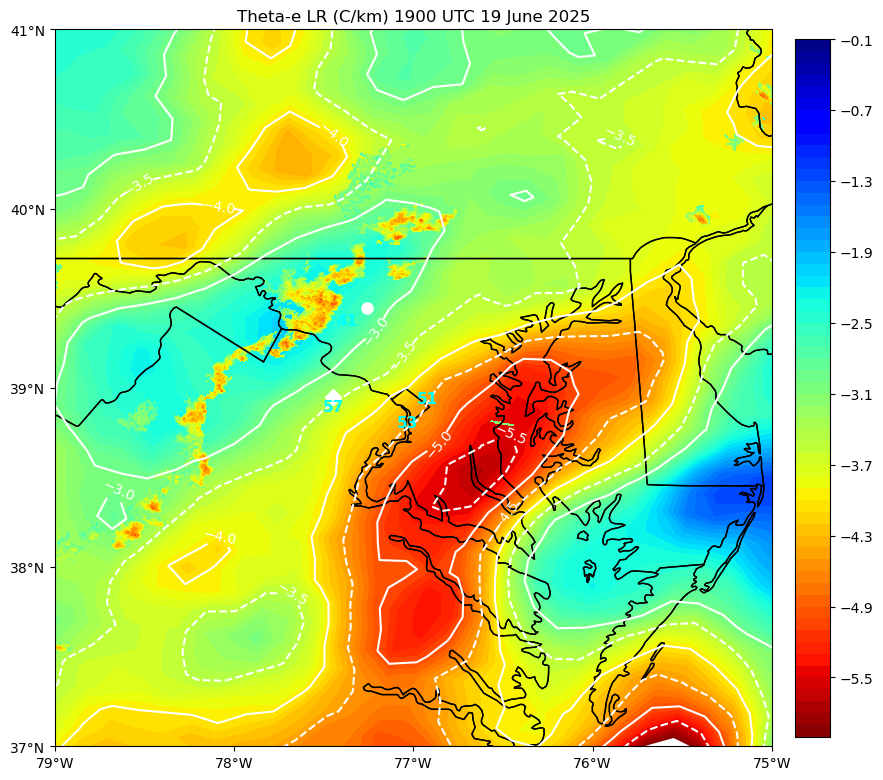

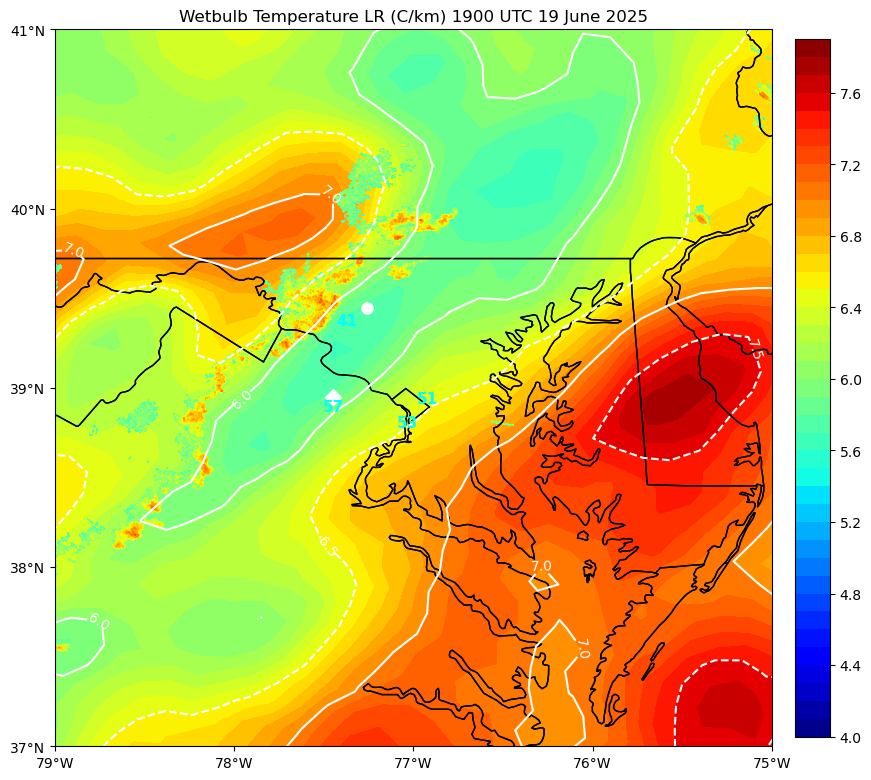

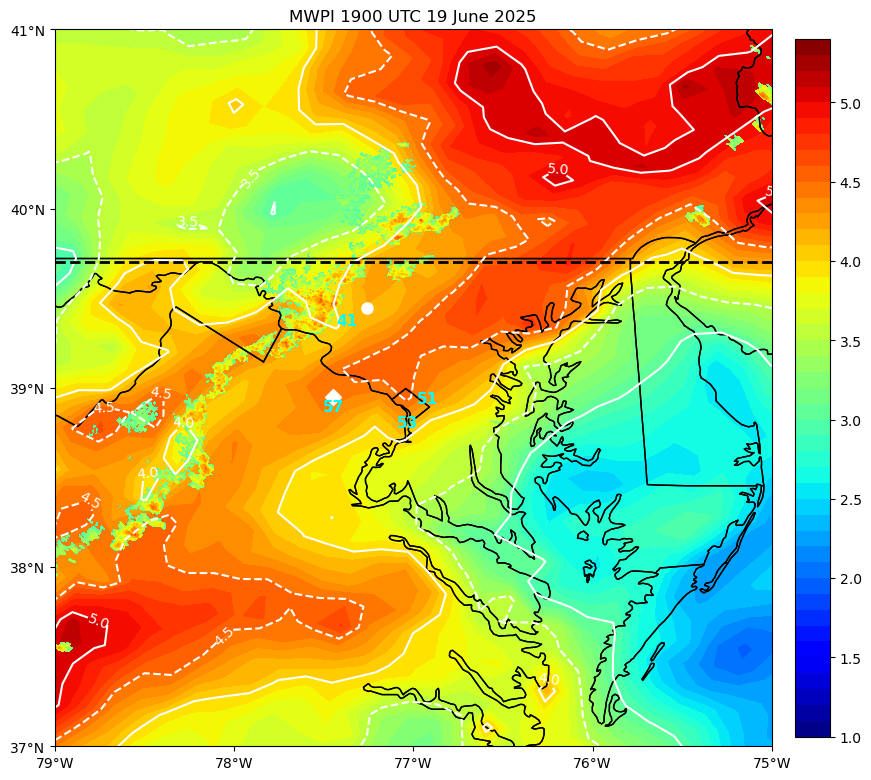

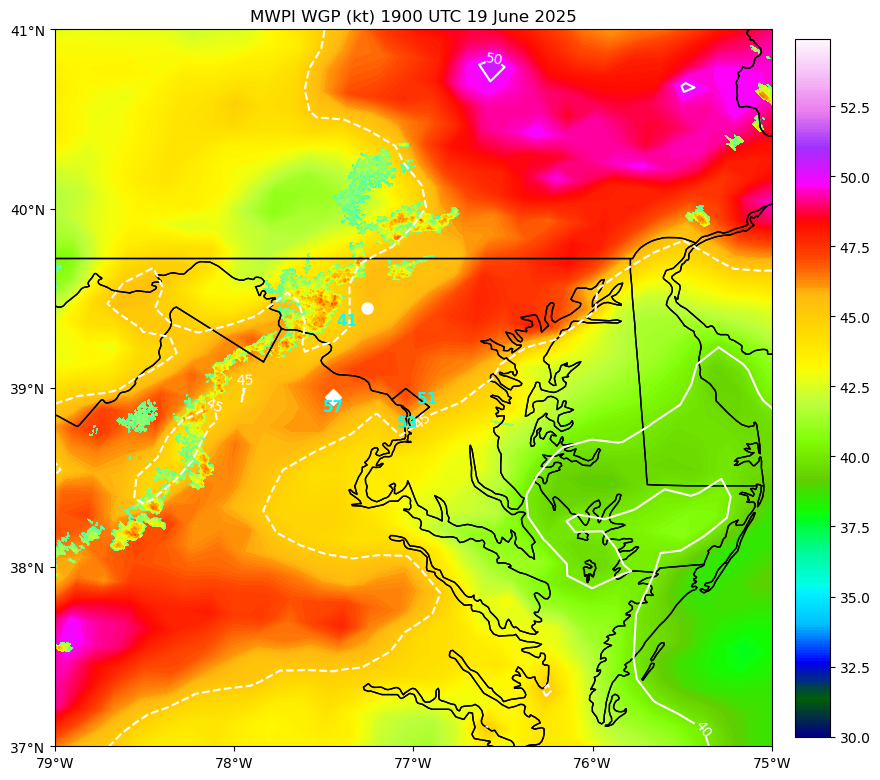

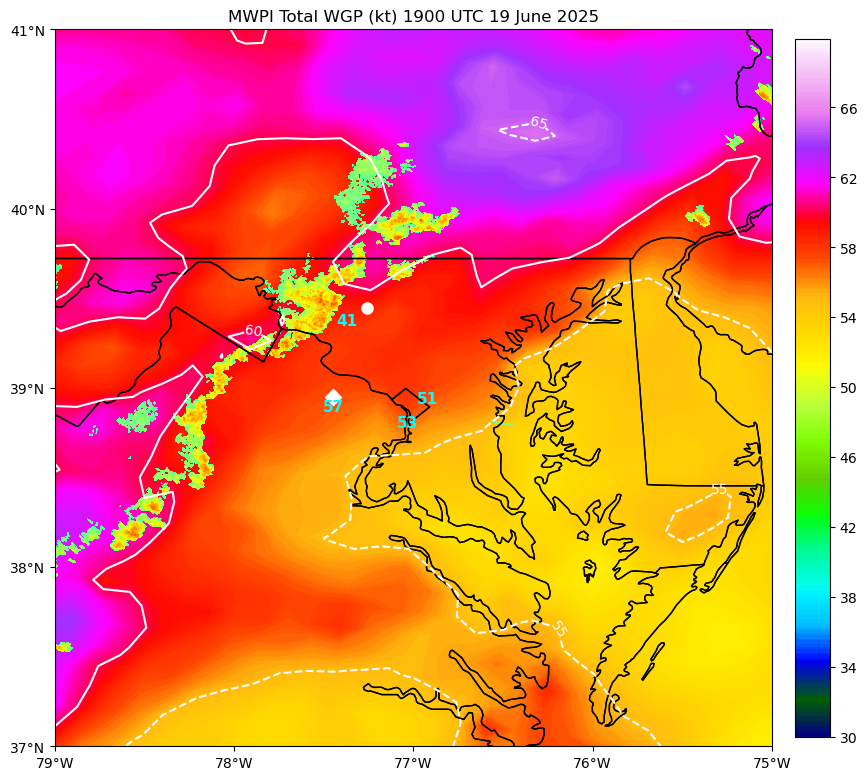

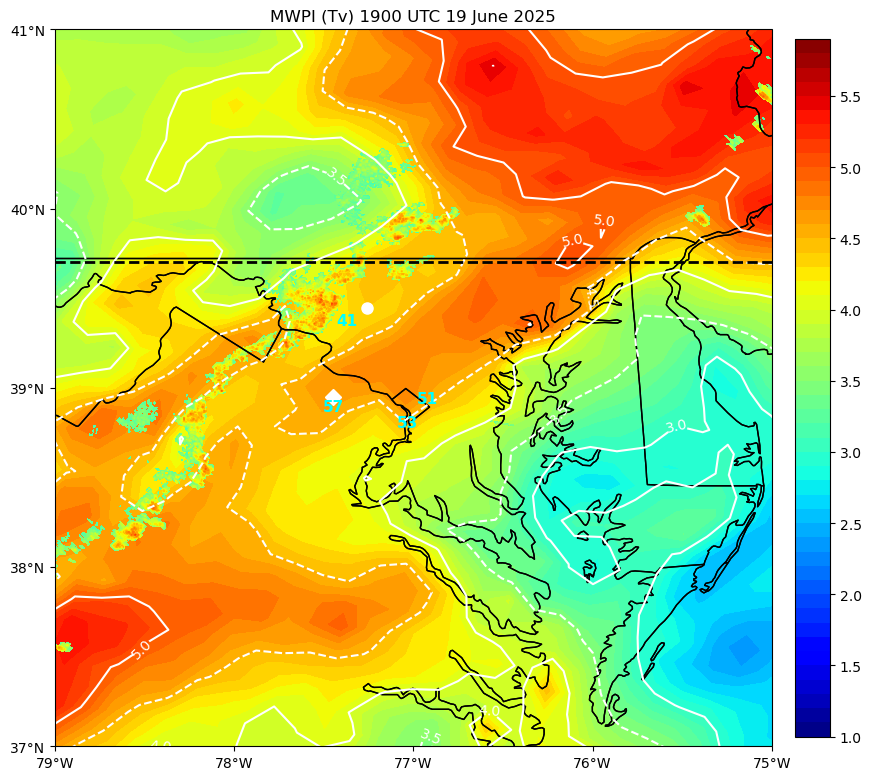

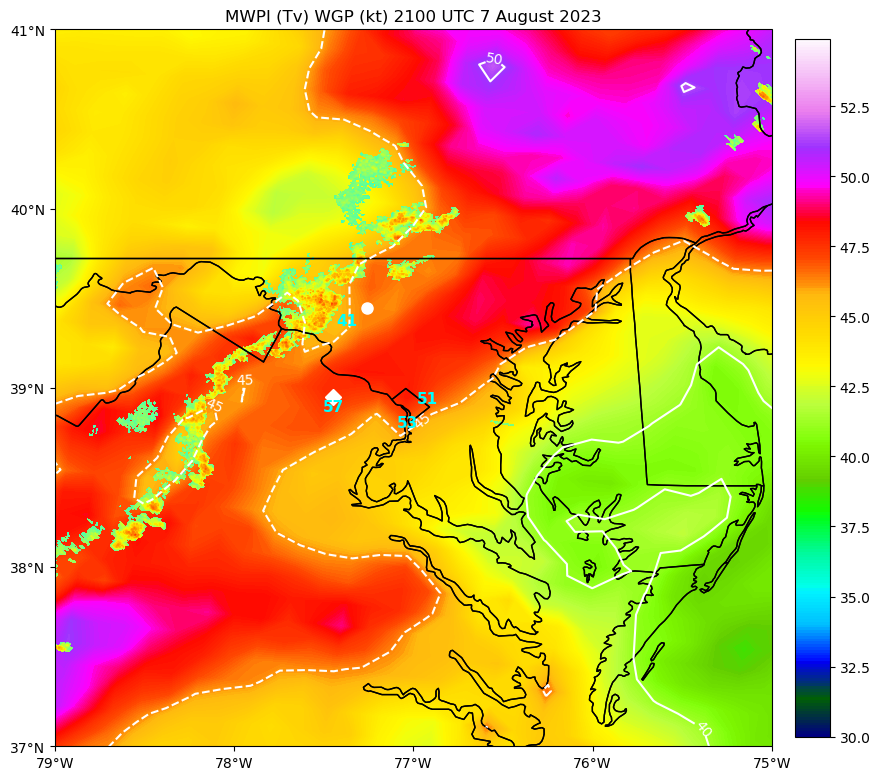

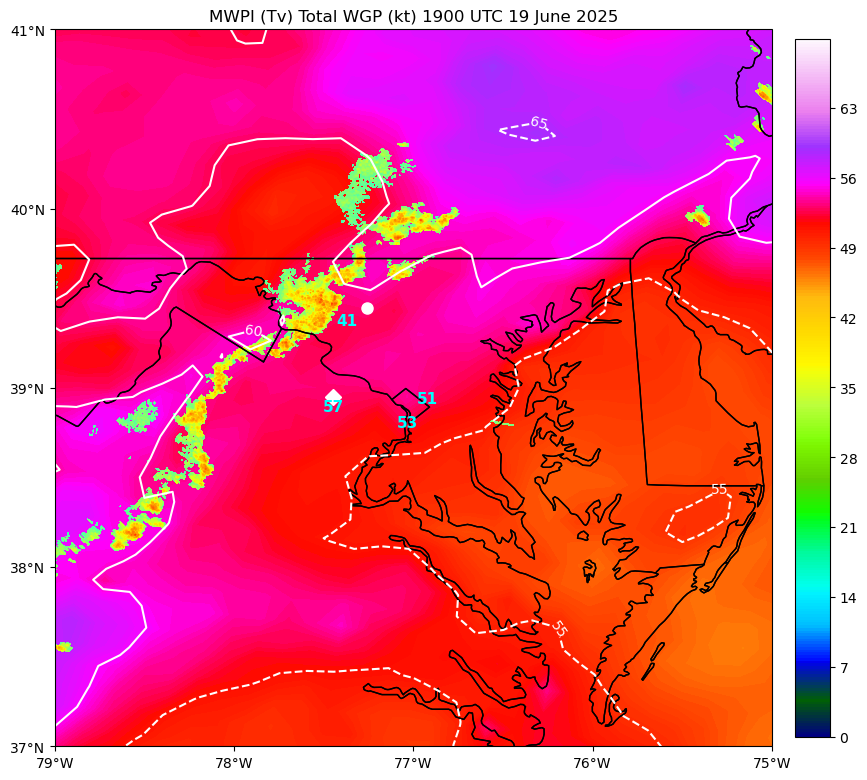

In [13]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter

Z_upper = height_km_800
Z_lower = height_km_950
T_upper = temperature_c_800
T_lower = temperature_c_950
Tv_upper = tempvirt_c_800
Tv_lower = tempvirt_c_950
Te_upper = thetae_800
Te_lower = thetae_950
TD_upper = dewpoint_c_800
TD_lower = dewpoint_c_950
wetbulb_upper = wetbulb_800
wetbulb_lower = wetbulb_950
CAPE = cape
SM_mag_kt = SM_mag * 1.94384
 
def MWPI_2D(Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE, SM_mag_kt):
        gamma = (T_lower - T_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = T_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = T_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI = (CAPE/1000.0) + (gamma/5.0) + (DDD/5.0)
        WGP = (0.35435365777 * (MWPI**2)) + (1.2959855*MWPI) + 33.8176788
        WGP_tot = WGP + (SM_mag_kt/3)
        return MWPI, WGP, WGP_tot

def MWPI_2D_Tv(Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE, SM_mag_kt):
        SM_mag_kt = SM_mag
        gamma = (Tv_lower - Tv_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = T_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = T_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI_Tv = (CAPE/1000.0) + (gamma/5.0) + (DDD/5.0)
        WGP_Tv = (0.35435365777 * (MWPI_Tv**2)) + (1.2959855*MWPI_Tv) + 33.8176788
        WGP_tot_Tv = WGP_Tv + (SM_mag_kt/3)
        return MWPI_Tv, WGP_Tv, WGP_tot_Tv 

def GAMMA_2D(Z_upper, Z_lower, Te_upper, Te_lower, Tv_upper, Tv_lower, wetbulb_upper, wetbulb_lower):
        gamma_Te = (Te_lower - Te_upper)/(Z_lower - Z_upper)
        print("TE Gamma = ", gamma_Te, gamma_Te.shape)
        gamma_Tv = (Tv_lower - Tv_upper)/(Z_upper - Z_lower)
        print("Tv Gamma = ", gamma_Tv, gamma_Tv.shape)
        gamma_wb = (wetbulb_lower - wetbulb_upper)/(Z_upper - Z_lower)
        print("WB Gamma = ", gamma_wb, gamma_wb.shape)
        return gamma_Te, gamma_Tv, gamma_wb

def read_radar_plot(ncf):
    nc_fid = Dataset(ncf, 'r')
    Z = nc_fid.variables["Reflectivity"][:]  # shape lat, lon as shown above
    lat = nc_fid.variables['lat'][:]  # extract/copy the data
    lon = nc_fid.variables['lon'][:]
    names = nc_fid.variables.keys()
    nc_fid.close()
    return Z, lat, lon, names

def make_radar_mask(Z,lat,lon):
    Z[Z>70]=69
    print('Z shape', Z.shape, Z)
    Z_30 = ma.masked_where(Z < 30, Z)
    print('Z_30 shape', Z_30.shape)
    Z_40 = ma.masked_where(Z < 40, Z)
    print('Z_40 shape', Z_40.shape)
    lonz,latz = np.meshgrid(lon,lat)
    print('lats shape, lons shape', latz.shape, lonz.shape, latz,lonz)
    return Z_30, Z_40, lonz, latz

Z_file_LWX = 'KLWX_V06_20250619_190038.nc'
Z_LWX, lat_lwx, lon_lwx, names = read_radar_plot(Z_file_LWX)
Z_LWX = Z_LWX[0,:,:]
Z_LWX = np.nan_to_num(Z_LWX)
Z_LWX_G = gaussian_filter(Z_LWX, sigma=3)
print(names)
print('Z_LWX shape', Z_LWX.shape, Z_LWX)
Z_LWX_max = np.amax(Z_LWX)
Z_LWX_min = np.amin(Z_LWX)
print('Z_LWX min, Z_LWX max', Z_LWX_min, Z_LWX_max)
print('lat shape, lon shape', lat_lwx.shape, lon_lwx.shape)

Z_30_LWX, Z_40_LWX, lonz_lwx, latz_lwx = make_radar_mask(Z_LWX, lat_lwx, lon_lwx)

mwpi, mwpi_wgp, wgp_tot = MWPI_2D(Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE, SM_mag_kt) 
mwpi = mwpi[0,:,:]    
print("MWPI: ", mwpi, mwpi.shape, mwpi.min(), mwpi.max())
mwpi_wgp = mwpi_wgp[0,:,:]
print("WGP: ", mwpi_wgp, mwpi_wgp.shape, mwpi_wgp.min(), mwpi_wgp.max())
mwpi_wgp_mph = mwpi_wgp * 1.151
wgp_tot = wgp_tot[0,:,:]
print("Total WGP: ", wgp_tot, wgp_tot.shape, wgp_tot.min(), wgp_tot.max())
wgp_tot_mph = wgp_tot * 1.151

mwpi_Tv, mwpi_wgp_Tv, wgp_tot_Tv = MWPI_2D_Tv(Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE, SM_mag_kt) 
mwpi_Tv = mwpi_Tv[0,:,:]  
print("Tv MWPI: ", mwpi_Tv, mwpi_Tv.shape, mwpi_Tv.min(), mwpi_Tv.max())
mwpi_wgp_Tv = mwpi_wgp_Tv[0,:,:]
print("Tv WGP: ", mwpi_wgp_Tv, mwpi_wgp_Tv.shape, mwpi_wgp_Tv.min(), mwpi_wgp_Tv.max())
mwpi_wgp_Tv_mph = mwpi_wgp_Tv * 1.151
wgp_tot_Tv = wgp_tot_Tv[0,:,:]
print("Tv Total WGP: ", wgp_tot_Tv, wgp_tot_Tv.shape, wgp_tot_Tv.min(), wgp_tot_Tv.max())
wgp_tot_Tv_mph = wgp_tot_Tv * 1.151

gamma_Te, gamma_Tv, gamma_wb = GAMMA_2D(Z_upper, Z_lower, Te_upper, Te_lower, Tv_upper, Tv_lower, wetbulb_upper, wetbulb_lower) 

fig = plt.figure(figsize=(10, 12))
img_extent = (-78.5, -75.5, 37.5, 40.5)
ax = plt.axes(projection=crs.PlateCarree(globe=None))
ax.set_extent([-78.5, -75.5, 37.5, 40.5], crs.PlateCarree(globe=None))

plt.title('Theta-e LR (C/km) 1900 UTC 19 June 2025')

LRlevels = np.arange(-6,0,0.1)
cte = ax.contourf(lons,lats,gamma_Te,LRlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='jet_r')
ctelr = ax.contour(lons,lats,gamma_Te,levels=[-6, -5.5, -5, -4.5, -4, -3.5, -3],extent=img_extent, transform=crs.PlateCarree(globe=None),colors='white',linestyles=['solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed', 'solid'])
ax.clabel(ctelr, fontsize=10, inline=True, levels=[-6, -5.5, -5, -4.5, -4, -3.5, -3])
Zlevels = np.arange(30,70,1)
cZ1 = ax.contourf(lonz_lwx,latz_lwx,Z_30_LWX,Zlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='jet',vmin=0,vmax=70)
ax.set_xticks([-79,-78,-77,-76,-75])
ax.set_yticks([37,38,39,40,41])

ax.plot(-77.256, 39.447, 'ow', markersize=8, transform=crs.Geodetic())
ax.plot(-77.45, 38.95, 'Dw', markersize=8, transform=crs.Geodetic())
ax.text(-77.36982, 39.41775, '41', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.44750, 38.93472, '57', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.03417, 38.84833, '53', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-76.92230, 38.98060, '51', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())

#plt.plot([-79, -75], [39.70427305681921, 39.70427305681921], linestyle='--',
#         color='black', linewidth=2, transform=crs.PlateCarree(globe=None))

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cbar=plt.colorbar(cte,fraction=0.045,pad=0.03)
plt.savefig("telr_map_1900.png",dpi=250,bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10, 12))
img_extent = (-78.5, -75.5, 37.5, 40.5)
ax = plt.axes(projection=crs.PlateCarree(globe=None))
ax.set_extent([-78.5, -75.5, 37.5, 40.5], crs.PlateCarree(globe=None))

plt.title('Wetbulb Temperature LR (C/km) 1900 UTC 19 June 2025')

LRlevels = np.arange(4,8,0.1)
cwb = ax.contourf(lons,lats,gamma_wb,LRlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='jet')
cwblr = ax.contour(lons,lats,gamma_wb,levels=[5, 5.5, 6, 6.5, 7, 7.5, 8],extent=img_extent, transform=crs.PlateCarree(globe=None),colors='white',linestyles=['solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed', 'solid'])
ax.clabel(cwblr, fontsize=10, inline=True, levels=[5, 5.5, 6, 6.5, 7, 7.5, 8])
Zlevels = np.arange(30,70,1)
cZ1 = ax.contourf(lonz_lwx,latz_lwx,Z_30_LWX,Zlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='jet',vmin=0,vmax=70)
ax.set_xticks([-79,-78,-77,-76,-75])
ax.set_yticks([37,38,39,40,41])

ax.plot(-77.256, 39.447, 'ow', markersize=8, transform=crs.Geodetic())
ax.plot(-77.45, 38.95, 'Dw', markersize=8, transform=crs.Geodetic())
ax.text(-77.36982, 39.41775, '41', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.44750, 38.93472, '57', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.03417, 38.84833, '53', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-76.92230, 38.98060, '51', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cbar=plt.colorbar(cwb,fraction=0.045,pad=0.03)
plt.savefig("wblr_map_1900.png",dpi=250,bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10, 12))
img_extent = (-78.5, -75.5, 37.5, 40.5)
ax = plt.axes(projection=crs.PlateCarree(globe=None))
ax.set_extent([-78.5, -75.5, 37.5, 40.5], crs.PlateCarree(globe=None))

plt.title('MWPI 1900 UTC 19 June 2025')

Mlevels = np.arange(1,5.5,0.1)
cmwp = ax.contourf(lons,lats,mwpi,Mlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='jet')
cmwpi = ax.contour(lons,lats,mwpi,levels=[3, 3.5, 4, 4.5, 5],extent=img_extent, transform=crs.PlateCarree(globe=None),colors='white',linestyles=['solid', 'dashed', 'solid', 'dashed', 'solid'])
ax.clabel(cmwpi, fontsize=10, inline=True, levels=[3, 3.5, 4, 4.5, 5])
Zlevels = np.arange(30,70,1)
cZ1 = ax.contourf(lonz_lwx,latz_lwx,Z_30_LWX,Zlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='jet',vmin=0,vmax=70)
ax.set_xticks([-79,-78,-77,-76,-75])
ax.set_yticks([37,38,39,40,41])

ax.plot(-77.256, 39.447, 'ow', markersize=8, transform=crs.Geodetic())
ax.plot(-77.45, 38.95, 'Dw', markersize=8, transform=crs.Geodetic())
ax.text(-77.36982, 39.41775, '41', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.44750, 38.93472, '57', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.03417, 38.84833, '53', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-76.92230, 38.98060, '51', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())

plt.plot([-79, -75], [39.70427305681921, 39.70427305681921], linestyle='--',
         color='black', linewidth=2, transform=crs.PlateCarree(globe=None))

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cbar=plt.colorbar(cmwp,fraction=0.045,pad=0.03)
plt.savefig("mwpi_map_1900.png",dpi=250,bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10, 12))
img_extent = (-78.5, -75.5, 37.5, 40.5)
ax = plt.axes(projection=crs.PlateCarree(globe=None))
ax.set_extent([-78.5, -75.5, 37.5, 40.5], crs.PlateCarree(globe=None))

plt.title('MWPI WGP (kt) 1900 UTC 19 June 2025')

Wlevels = np.arange(30,55,0.1)
cwg = ax.contourf(lons,lats,mwpi_wgp,Wlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='gist_ncar')
cwgp = ax.contour(lons,lats,mwpi_wgp,levels=[30, 35, 40, 45, 50],extent=img_extent, transform=crs.PlateCarree(globe=None),colors='white',linestyles=['solid', 'dashed', 'solid', 'dashed', 'solid'])
ax.clabel(cwgp, fontsize=10, inline=True, levels=[30, 35, 40, 45, 50])
Zlevels = np.arange(30,70,1)
cZ1 = ax.contourf(lonz_lwx,latz_lwx,Z_30_LWX,Zlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='jet',vmin=0,vmax=70)

ax.set_xticks([-79,-78,-77,-76,-75])
ax.set_yticks([37,38,39,40,41])

ax.plot(-77.256, 39.447, 'ow', markersize=8, transform=crs.Geodetic())
ax.plot(-77.45, 38.95, 'Dw', markersize=8, transform=crs.Geodetic())
ax.text(-77.36982, 39.41775, '41', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.44750, 38.93472, '57', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.03417, 38.84833, '53', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-76.92230, 38.98060, '51', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())

#plt.plot([-79, -75], [39.70427305681921, 39.70427305681921], linestyle='--',
#         color='black', linewidth=2, transform=crs.PlateCarree(globe=None))

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cbar=plt.colorbar(cwg,fraction=0.045,pad=0.03)
plt.savefig("mwpi_wgp_map_1900.png",dpi=250,bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10, 12))
img_extent = (-78.5, -75.5, 37.5, 40.5)
ax = plt.axes(projection=crs.PlateCarree(globe=None))
ax.set_extent([-78.5, -75.5, 37.5, 40.5], crs.PlateCarree(globe=None))

plt.title('MWPI Total WGP (kt) 1900 UTC 19 June 2025')

Wlevels = np.arange(30,70,0.1)
cwg = ax.contourf(lons,lats,wgp_tot,Wlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='gist_ncar')
cwgp = ax.contour(lons,lats,wgp_tot,levels=[30, 35, 40, 45, 50, 55, 60, 65, 70],extent=img_extent, transform=crs.PlateCarree(globe=None),colors='white',linestyles=['solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed', 'solid'])
ax.clabel(cwgp, fontsize=10, inline=True, levels=[30, 35, 40, 45, 50, 55, 60, 65, 70])
Zlevels = np.arange(30,70,1)
cZ1 = ax.contourf(lonz_lwx,latz_lwx,Z_30_LWX,Zlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='jet',vmin=0,vmax=70)
ax.set_xticks([-79,-78,-77,-76,-75])
ax.set_yticks([37,38,39,40,41])

ax.plot(-77.256, 39.447, 'ow', markersize=8, transform=crs.Geodetic())
ax.plot(-77.45, 38.95, 'Dw', markersize=8, transform=crs.Geodetic())
ax.text(-77.36982, 39.41775, '41', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.44750, 38.93472, '57', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.03417, 38.84833, '53', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-76.92230, 38.98060, '51', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())

#plt.plot([-79, -75], [39.70427305681921, 39.70427305681921], linestyle='--',
#         color='black', linewidth=2, transform=crs.PlateCarree(globe=None))

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cbar=plt.colorbar(cwg,fraction=0.045,pad=0.03)
plt.savefig("mwpi_tot_wgp_map_1900.png",dpi=250,bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10, 12))
img_extent = (-78.5, -75.5, 37.5, 40.5)
ax = plt.axes(projection=crs.PlateCarree(globe=None))
ax.set_extent([-78.5, -75.5, 37.5, 40.5], crs.PlateCarree(globe=None))

plt.title('MWPI (Tv) 1900 UTC 19 June 2025')

Mlevels = np.arange(1,6,0.1)
cmwp = ax.contourf(lons,lats,mwpi_Tv,Mlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='jet')
cmwpi = ax.contour(lons,lats,mwpi_Tv,levels=[3, 3.5, 4, 4.5, 5, 5.5, 6],extent=img_extent, transform=crs.PlateCarree(globe=None),colors='white',linestyles=['solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed', 'solid'])
ax.clabel(cmwpi, fontsize=10, inline=True, levels=[3, 3.5, 4, 4.5, 5, 5.5, 6])
Zlevels = np.arange(30,70,1)
cZ1 = ax.contourf(lonz_lwx,latz_lwx,Z_30_LWX,Zlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='jet',vmin=0,vmax=70)

ax.set_xticks([-79,-78,-77,-76,-75])
ax.set_yticks([37,38,39,40,41])

ax.plot(-77.256, 39.447, 'ow', markersize=8, transform=crs.Geodetic())
ax.plot(-77.45, 38.95, 'Dw', markersize=8, transform=crs.Geodetic())
ax.text(-77.36982, 39.41775, '41', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.44750, 38.93472, '57', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.03417, 38.84833, '53', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-76.92230, 38.98060, '51', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())

plt.plot([-79, -75], [39.70427305681921, 39.70427305681921], linestyle='--',
         color='black', linewidth=2, transform=crs.PlateCarree(globe=None))

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cbar=plt.colorbar(cmwp,fraction=0.045,pad=0.03)
plt.savefig("mwpi_Tv_map_1900.png",dpi=250,bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10, 12))
img_extent = (-78.5, -75.5, 37.5, 40.5)
ax = plt.axes(projection=crs.PlateCarree(globe=None))
ax.set_extent([-78.5, -75.5, 37.5, 40.5], crs.PlateCarree(globe=None))

plt.title('MWPI (Tv) WGP (kt) 2100 UTC 7 August 2023')

Wlevels = np.arange(30,55,0.1)
cwg = ax.contourf(lons,lats,mwpi_wgp_Tv,Wlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='gist_ncar')
cwgp = ax.contour(lons,lats,mwpi_wgp,levels=[30, 35, 40, 45, 50, 55],extent=img_extent, transform=crs.PlateCarree(globe=None),colors='white',linestyles=['solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed'])
ax.clabel(cwgp, fontsize=10, inline=True, levels=[30, 35, 40, 45, 50, 55])
Zlevels = np.arange(30,70,1)
cZ1 = ax.contourf(lonz_lwx,latz_lwx,Z_30_LWX,Zlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='jet',vmin=0,vmax=70)

ax.set_xticks([-79,-78,-77,-76,-75])
ax.set_yticks([37,38,39,40,41])

ax.plot(-77.256, 39.447, 'ow', markersize=8, transform=crs.Geodetic())
ax.plot(-77.45, 38.95, 'Dw', markersize=8, transform=crs.Geodetic())
ax.text(-77.36982, 39.41775, '41', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.44750, 38.93472, '57', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.03417, 38.84833, '53', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-76.92230, 38.98060, '51', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())

#plt.plot([-79, -75], [39.70427305681921, 39.70427305681921], linestyle='--',
#         color='black', linewidth=2, transform=crs.PlateCarree(globe=None))

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cbar=plt.colorbar(cwg,fraction=0.045,pad=0.03)
plt.savefig("mwpi_wgp_Tv_map_1900.png",dpi=250,bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10, 12))
img_extent = (-78.5, -75.5, 37.5, 40.5)
ax = plt.axes(projection=crs.PlateCarree(globe=None))
ax.set_extent([-78.5, -75.5, 37.5, 40.5], crs.PlateCarree(globe=None))

plt.title('MWPI (Tv) Total WGP (kt) 1900 UTC 19 June 2025')

Wlevels = np.arange(0,70,0.1)
cwg = ax.contourf(lons,lats,wgp_tot_Tv,Wlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='gist_ncar')
cwgp = ax.contour(lons,lats,wgp_tot,levels=[30, 35, 40, 45, 50, 55, 60, 65, 70],extent=img_extent, transform=crs.PlateCarree(globe=None),colors='white',linestyles=['solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed', 'solid'])
ax.clabel(cwgp, fontsize=10, inline=True, levels=[30, 35, 40, 45, 50, 55, 60, 65, 70])
Zlevels = np.arange(30,70,1)
cZ1 = ax.contourf(lonz_lwx,latz_lwx,Z_30_LWX,Zlevels,extent=img_extent,transform=crs.PlateCarree(globe=None),cmap='jet',vmin=0,vmax=70)

ax.set_xticks([-79,-78,-77,-76,-75])
ax.set_yticks([37,38,39,40,41])

ax.plot(-77.256, 39.447, 'ow', markersize=8, transform=crs.Geodetic())
ax.plot(-77.45, 38.95, 'Dw', markersize=8, transform=crs.Geodetic())
ax.text(-77.36982, 39.41775, '41', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.44750, 38.93472, '57', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-77.03417, 38.84833, '53', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())
ax.text(-76.92230, 38.98060, '51', color='cyan', weight='bold', fontsize=11, ha='center', va='top', style='normal', transform=crs.Geodetic())

#plt.plot([-79, -75], [39.70427305681921, 39.70427305681921], linestyle='--',
#         color='black', linewidth=2, transform=crs.PlateCarree(globe=None))

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cbar=plt.colorbar(cwg,fraction=0.045,pad=0.03)
plt.savefig("mwpi_tot_wgp_Tv_map_1900.png",dpi=250,bbox_inches='tight')
plt.show()

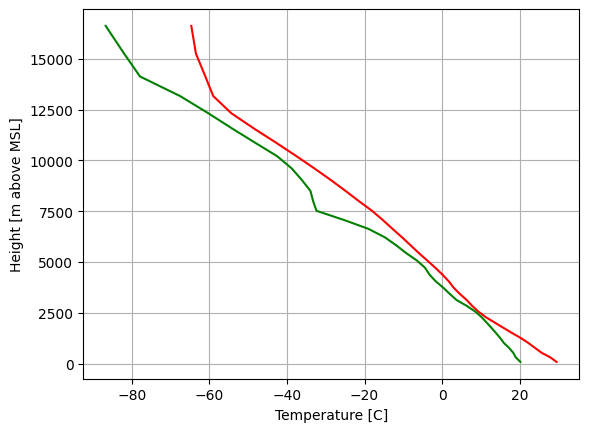

SURFACE HEIGHT (m MSL): 78.39
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 78.39


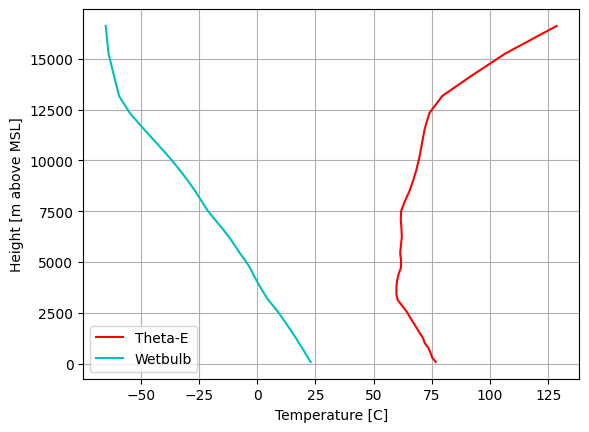

Most-Unstable CAPE: 1600.78
Surface-based CAPE: 1600.78
Most-Unstable LCL: 1192.62
Most-Unstable LFC: 1574.197849834223
Most-Unstable EL: 12736.68
Most-Unstable LI: -5.14
670-850 mb Lapse Rate: 7.44
850-950 mb Lapse Rate: 8.3
Maximum Lapse Rate: 6.2
MWPI: 3.89
T Totals: 48.18
K-index: 37.43
TEI: 16.88
MWPI WGP (kt): 44.22
SB CAPE =  1600.7757888136723
MU CAPE =  1600.7757888136723
CAPE Ratio =  0.0
Surface-based convection


/data/home004/ken.pryor/.conda/envs/devel/lib/python3.9/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
/data/home004/ken.pryor/.conda/envs/devel/lib/python3.9/site-packages/SHARPpy-0+unknown-py3.9.egg/sharppy/sharptab/params.py:2275: RuntimeWarning: divide by zero encountered in double_scalars
  pcl.brn = pcl.bplus / pcl.brnshear


In [1]:
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

spc_file = open('RAP_FDK_0619_1900.txt', 'r').read()

import numpy as np
from io import StringIO

def parseSPC(spc_file):
    """
        This function will read a SPC-style formatted observed sounding file,
        similar to that of the 14061619.OAX file included in the SHARPpy distribution.

        It will return the pressure, height, temperature, dewpoint, wind direction and wind speed data
        from that file.
    """
    ## read in the file
    data = np.array([l.strip() for l in spc_file.split('\n')])

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0] + 1
    finish_idx = np.where( data == '%END%')[0]

    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx[0] : finish_idx[0]][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )

    return p, h, T, Td, wdir, wspd

pres, hght, tmpc, dwpc, wdir, wspd = parseSPC(spc_file)

prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, wspd=wspd, wdir=wdir, missing=-9999, strictQC=True)

import matplotlib.pyplot as plt
plt.plot(prof.tmpc, prof.hght, 'r-')
plt.plot(prof.dwpc, prof.hght, 'g-')
#plt.barbs(40*np.ones(len(prof.hght)), prof.hght, prof.u, prof.v)
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.grid()
plt.show()

msl_hght = prof.hght[prof.sfc] # Grab the surface height value
print("SURFACE HEIGHT (m MSL):",msl_hght)
agl_hght = interp.to_agl(prof, msl_hght) # Converts to AGL
print("SURFACE HEIGHT (m AGL):", agl_hght)
msl_hght = interp.to_msl(prof, agl_hght) # Converts to MSL
print("SURFACE HEIGHT (m MSL):",msl_hght)

plt.plot(thermo.ktoc(prof.thetae), prof.hght, 'r-', label='Theta-E')
plt.plot(prof.wetbulb, prof.hght, 'c-', label='Wetbulb')
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.legend()
plt.grid()
plt.show()

def lapse_rate(prof, lower, upper, pres=True):
    '''
        Calculates the lapse rate (C/km) from a profile object

        Parameters
        ----------
        prof : profile object
            Profile Object
        lower : number
            Lower Bound of lapse rate (mb or m AGL)
        upper : number
            Upper Bound of lapse rate (mb or m AGL)
        pres : bool (optional; default = True)
            Flag to determine if lower/upper are pressure [True]
            or height [False]

        Returns
        -------
        lapse rate (C/km) : number
        '''
    if pres:
        if (prof.pres[-1] > upper): return ma.masked
        p1 = lower
        p2 = upper
        z1 = interp.hght(prof, lower)
        z2 = interp.hght(prof, upper)
    else:
        z1 = interp.to_msl(prof, lower)
        z2 = interp.to_msl(prof, upper)
        p1 = interp.pres(prof, z1)
        p2 = interp.pres(prof, z2)
    tv1 = interp.vtmp(prof, p1)
    tv2 = interp.vtmp(prof, p2)
    return (tv2 - tv1) / (z2 - z1) * -1000.

def max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000):
    '''
        Calculates the maximum lapse rate (C/km) between a layer at a specified interval

        Parameters
        ----------
        prof: profile object
            Profile object
        lower : number
            Lower bound in height (m)
        upper : number
            Upper bound in height (m)
        interval : number
            Interval to assess the lapse rate at (m)
        depth : number
            Depth of the layer to assess the lapse rate over (m)

        Returns
        -------
        max lapse rate (C/km) : float
        lower pressure of max lapse rate (mb) : number
        upper pressure of max lapse rate (mb) : number
    '''

    bottom_levels = interp.to_msl(prof, np.arange(lower, upper-depth+interval, interval))
    top_levels = interp.to_msl(prof, np.arange(lower+depth, upper+interval, interval))
    bottom_pres = interp.pres(prof, bottom_levels)
    top_pres = interp.pres(prof, top_levels)
    all_lapse_rates = (interp.vtmp(prof, top_pres) - interp.vtmp(prof, bottom_pres)) * -1000.
    max_lapse_rate_idx = np.ma.argmax(all_lapse_rates)
    return all_lapse_rates[max_lapse_rate_idx]/depth, bottom_pres[max_lapse_rate_idx], top_pres[max_lapse_rate_idx]

def mwpi(prof):
    '''
        Microburst Windspeed Potential Index (MWPI)

        Formulated by Kenneth Pryor NOAA/NESDIS/STAR
        
        The Microburst Windspeed Potential Index (MWPI) is designed to quantify the most relevant factors
        in convective downburst generation in intermediate thermodynamic environments by incorporating 1) surface-based
        CAPE, 2) the temperature lapse rate between the 670- and 850-mb levels, and 3) DDD between the 670- and
        850-mb levels. The MWPI formula consists of a set of predictor variables (i.e., dewpoint depression
        and temperature lapse rate) that generates output of the expected microburst risk. 
        Scaling factors of 1000 J/kg, 5 C/km, and 5 C, respectively, are applied to the MWPI algorithm
        to yield a unitless MWPI value that expresses wind gust potential on a scale from 1 to 5:

        MWPI = (CAPE/1000) + LR/5 + DDD/5 
        
        Reference:
        Pryor, K. L., 2015: Progress and Developments of Downburst Prediction Applications of GOES. Wea. Forecasting, 30, 1182–1200.
        
        Parameters
        ----------
        prof : Profile object

        Returns
        -------
        mwpi : number
            MWPI (unitless)
    '''
    sbpcl = getattr(prof, 'sfcpcl', params.parcelx(prof, flag=1))
    sb_cape = sbpcl.bplus
    
    mupcl = getattr(prof, 'mupcl', params.parcelx(prof, flag=1))
    mu_cape = mupcl.bplus
    lr_hi = lapse_rate(prof, 850, 670, pres=True)
    lr_lo = lapse_rate(prof, 950, 850, pres=True)
    sfc = prof.pres[prof.sfc]
    
    if lr_hi > lr_lo:
    #MWPI calculation for 670-850 mb layer
        lr850_670 = lapse_rate(prof, 850, 670, pres=True)
        t670 = interp.temp(prof, 670.)
        t850 = interp.temp(prof, 850.)
        td670 = interp.dwpt(prof, 670.)
        td850 = interp.dwpt(prof, 850.)
        dd670 = t670 - td670
        dd850 = t850 - td850
        ddd = dd850 - dd670
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr850_670/5) + (ddd/5)
    elif sfc < 950:
    #MWPI calculation for 670-850 mb layer
        lr850_670 = lapse_rate(prof, 850, 670, pres=True)
        t670 = interp.temp(prof, 670.)
        t850 = interp.temp(prof, 850.)
        td670 = interp.dwpt(prof, 670.)
        td850 = interp.dwpt(prof, 850.)
        dd670 = t670 - td670
        dd850 = t850 - td850
        ddd = dd850 - dd670
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr850_670/5) + (ddd/5)    
    else:
    #MWPI calculation for surface-based mixed layer
        lr950_850 = lapse_rate(prof, 950, 850, pres=True)
        t850 = interp.temp(prof, 850.)
        t950 = interp.temp(prof, 950.)
        td850 = interp.dwpt(prof, 850.)
        td950 = interp.dwpt(prof, 950.)
        dd850 = t850 - td850
        dd950 = t950 - td950
        ddd = dd950 - dd850
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr950_850/5) + (ddd/5)
    
    return mwpi

sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel
mu_cape = mupcl.bplus
mucape = str(round(mupcl.bplus,2))
print("Most-Unstable CAPE:", mucape) # J/kg
sb_cape = sfcpcl.bplus
sbcape = str(round(sfcpcl.bplus,2))
print("Surface-based CAPE:", sbcape) # J/kg
lcl = round(mupcl.lclhght,2)
lfc = mupcl.lfchght
el = round(mupcl.elhght,2)
li = str(round(mupcl.li5,2))
print("Most-Unstable LCL:", lcl) # meters AGL
print("Most-Unstable LFC:", lfc) # meters AGL
print("Most-Unstable EL:", el) # meters AGL
print("Most-Unstable LI:", li) # C
lr_hi = str(round(lapse_rate(prof, 850, 670, pres=True),2))
print("670-850 mb Lapse Rate:", lr_hi)
lr_lo = str(round(lapse_rate(prof, 950, 850, pres=True),2))
print("850-950 mb Lapse Rate:", lr_lo)
lapse_rate_max, bottom_pres, top_pres = max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000)
lr_max = str(round(lapse_rate_max,2))
print("Maximum Lapse Rate:", lr_max)
mwi = mwpi(prof)
mwp = round(mwi,2)
mwp_str = str(mwp)
print("MWPI:", mwp_str) 
t_tot = str(round(params.t_totals(prof),2))
print("T Totals:", t_tot)
k_idx = str(round(params.k_index(prof),2))
print("K-index:", k_idx)
te_idx = str(round(params.tei(prof),2))
print("TEI:", te_idx)
#WGP = (0.35435365777 * ((params.mwpi(prof))**2)) + (1.2959855*(params.mwpi(prof))) + 33.8176788
WGP = (0.35435365777 * (mwp**2)) + (1.2959855*mwp) + 33.8176788
mwpi_gp = str(round(WGP,2))
print("MWPI WGP (kt):", mwpi_gp)

#Calculate CAPE ratio
cape_ratio = 1 - ((sb_cape/mu_cape))
caperat = str(round(cape_ratio,2))
print("SB CAPE = ", sb_cape)
print("MU CAPE = ", mu_cape)
print("CAPE Ratio = ", caperat)
if cape_ratio > 0.3 and cape_ratio < 0.7:
    print("Hybrid Surface-based/elevated convection") 
elif cape_ratio >= 0.7:
    print("Elevated convection")
else:
    print("Surface-based convection") 

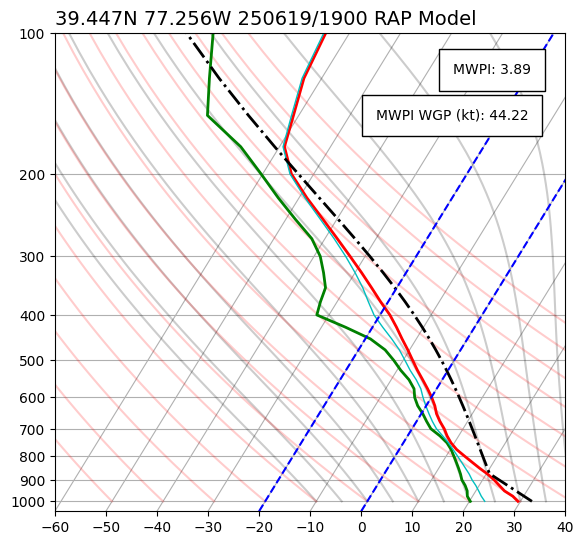

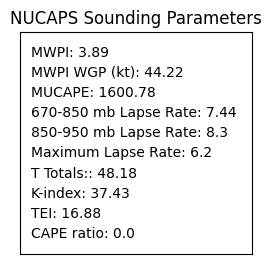

In [2]:
# Create a new figure. Plot a sounding emagram. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('39.447N 77.256W 250619/1900 RAP Model', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.tmpc, prof.pres, 'r', lw=2)
ax.semilogy(prof.dwpc, prof.pres, 'g', lw=2)
ax.semilogy(prof.wetbulb, prof.pres, 'c-', lw=1)

# Plot the parcel trace.
ax.semilogy(pcl.ttrace, pcl.ptrace, 'k-.', lw=2)

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-60,40)
xticks = np.arange(-60, 41, 10)
ax.set_xticks(xticks)

ax.text(-20, 120, r'MWPI: '+mwp_str, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
ax.text(-15, 150, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
# Show the plot to the user.
plt.savefig('skewt_rap_0619_1900.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
ax.set_title('NUCAPS Sounding Parameters')
#ax.set_xlabel('xlabel')
#ax.set_ylabel('ylabel')

# Set both x- and y-axis limits to [0, 10] instead of default [0, 1]
ax.axis([0, 10, 0, 11])
ax.text(0.5, 10, r'MWPI: '+mwp_str, size=10, ha='left', va='center')
ax.text(0.5, 9, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='left', va='center')
ax.text(0.5, 8, r'MUCAPE: '+mucape, size=10, ha='left', va='center')
ax.text(0.5, 7, r'670-850 mb Lapse Rate: '+lr_hi, size=10, ha='left', va='center')
ax.text(0.5, 6, r'850-950 mb Lapse Rate: '+lr_lo, size=10, ha='left', va='center')
ax.text(0.5, 5, r'Maximum Lapse Rate: '+lr_max, size=10, ha='left', va='center')
ax.text(0.5, 4, r'T Totals:: '+t_tot, size=10, ha='left', va='center')
ax.text(0.5, 3, r'K-index: '+k_idx, size=10, ha='left', va='center')
ax.text(0.5, 2, r'TEI: '+te_idx, size=10, ha='left', va='center')
ax.text(0.5, 1, r'CAPE ratio: '+caperat, size=10, ha='left', va='center')
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('skewt_rap_0619_1900_param.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

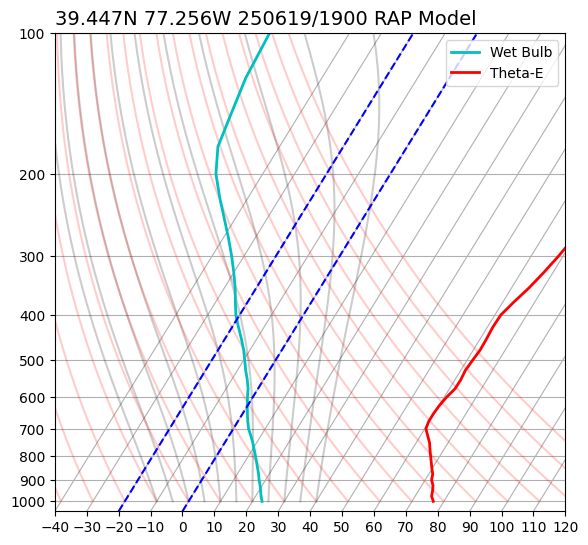

In [3]:
# Create a new figure. Plot a sounding emagram. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,150,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('39.447N 77.256W 250619/1900 RAP Model', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.wetbulb, prof.pres, 'c', lw=2, label='Wet Bulb')
ax.semilogy(thermo.ktoc(prof.thetae), prof.pres, 'r', lw=2, label='Theta-E')

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-40,120)
xticks = np.arange(-40, 121, 10)
ax.set_xticks(xticks)

# Show the plot to the user.
plt.legend()
plt.savefig('skewt_rap_0619_1900_wbte.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

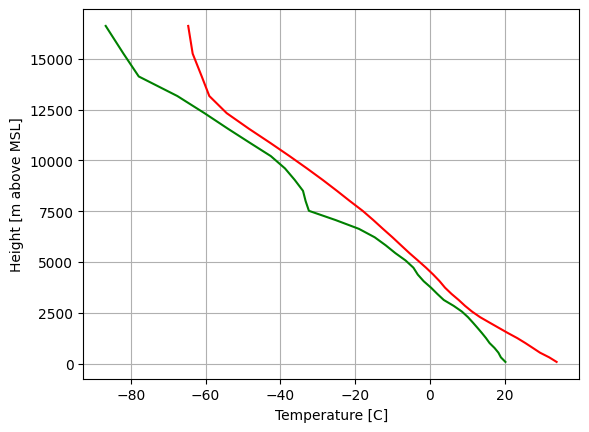

SURFACE HEIGHT (m MSL): 78.39
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 78.39


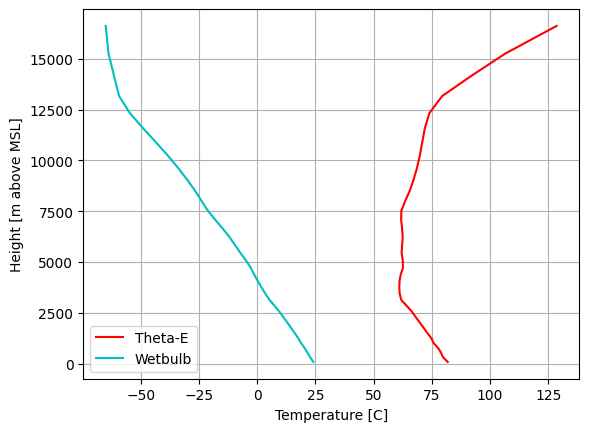

Most-Unstable CAPE: 2454.71
Surface-based CAPE: 2454.71
Most-Unstable LCL: 1722.27
Most-Unstable LFC: 1826.1965503267052
Most-Unstable EL: 13268.63
Most-Unstable LI: -6.74
670-850 mb Lapse Rate: 8.27
850-950 mb Lapse Rate: 9.37
Maximum Lapse Rate: 6.92
MWPI: 5.16
T Totals: 50.19
K-index: 38.48
TEI: 20.8
MWPI WGP (kt): 49.94
SB CAPE =  2454.7057225290596
MU CAPE =  2454.7057225290596
CAPE Ratio =  0.0
Surface-based convection


In [4]:
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

spc_file = open('RAP_Tv_FDK_0619_1900.txt', 'r').read()

import numpy as np
from io import StringIO

def parseSPC(spc_file):
    """
        This function will read a SPC-style formatted observed sounding file,
        similar to that of the 14061619.OAX file included in the SHARPpy distribution.

        It will return the pressure, height, temperature, dewpoint, wind direction and wind speed data
        from that file.
    """
    ## read in the file
    data = np.array([l.strip() for l in spc_file.split('\n')])

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0] + 1
    finish_idx = np.where( data == '%END%')[0]

    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx[0] : finish_idx[0]][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )

    return p, h, T, Td, wdir, wspd

pres, hght, tmpc, dwpc, wdir, wspd = parseSPC(spc_file)

prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, wspd=wspd, wdir=wdir, missing=-9999, strictQC=True)

import matplotlib.pyplot as plt
plt.plot(prof.tmpc, prof.hght, 'r-')
plt.plot(prof.dwpc, prof.hght, 'g-')
#plt.barbs(40*np.ones(len(prof.hght)), prof.hght, prof.u, prof.v)
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.grid()
plt.show()

msl_hght = prof.hght[prof.sfc] # Grab the surface height value
print("SURFACE HEIGHT (m MSL):",msl_hght)
agl_hght = interp.to_agl(prof, msl_hght) # Converts to AGL
print("SURFACE HEIGHT (m AGL):", agl_hght)
msl_hght = interp.to_msl(prof, agl_hght) # Converts to MSL
print("SURFACE HEIGHT (m MSL):",msl_hght)

plt.plot(thermo.ktoc(prof.thetae), prof.hght, 'r-', label='Theta-E')
plt.plot(prof.wetbulb, prof.hght, 'c-', label='Wetbulb')
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.legend()
plt.grid()
plt.show()

def lapse_rate(prof, lower, upper, pres=True):
    '''
        Calculates the lapse rate (C/km) from a profile object

        Parameters
        ----------
        prof : profile object
            Profile Object
        lower : number
            Lower Bound of lapse rate (mb or m AGL)
        upper : number
            Upper Bound of lapse rate (mb or m AGL)
        pres : bool (optional; default = True)
            Flag to determine if lower/upper are pressure [True]
            or height [False]

        Returns
        -------
        lapse rate (C/km) : number
        '''
    if pres:
        if (prof.pres[-1] > upper): return ma.masked
        p1 = lower
        p2 = upper
        z1 = interp.hght(prof, lower)
        z2 = interp.hght(prof, upper)
    else:
        z1 = interp.to_msl(prof, lower)
        z2 = interp.to_msl(prof, upper)
        p1 = interp.pres(prof, z1)
        p2 = interp.pres(prof, z2)
    tv1 = interp.vtmp(prof, p1)
    tv2 = interp.vtmp(prof, p2)
    return (tv2 - tv1) / (z2 - z1) * -1000.

def max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000):
    '''
        Calculates the maximum lapse rate (C/km) between a layer at a specified interval

        Parameters
        ----------
        prof: profile object
            Profile object
        lower : number
            Lower bound in height (m)
        upper : number
            Upper bound in height (m)
        interval : number
            Interval to assess the lapse rate at (m)
        depth : number
            Depth of the layer to assess the lapse rate over (m)

        Returns
        -------
        max lapse rate (C/km) : float
        lower pressure of max lapse rate (mb) : number
        upper pressure of max lapse rate (mb) : number
    '''

    bottom_levels = interp.to_msl(prof, np.arange(lower, upper-depth+interval, interval))
    top_levels = interp.to_msl(prof, np.arange(lower+depth, upper+interval, interval))
    bottom_pres = interp.pres(prof, bottom_levels)
    top_pres = interp.pres(prof, top_levels)
    all_lapse_rates = (interp.vtmp(prof, top_pres) - interp.vtmp(prof, bottom_pres)) * -1000.
    max_lapse_rate_idx = np.ma.argmax(all_lapse_rates)
    return all_lapse_rates[max_lapse_rate_idx]/depth, bottom_pres[max_lapse_rate_idx], top_pres[max_lapse_rate_idx]

def mwpi(prof):
    '''
        Microburst Windspeed Potential Index (MWPI)

        Formulated by Kenneth Pryor NOAA/NESDIS/STAR
        
        The Microburst Windspeed Potential Index (MWPI) is designed to quantify the most relevant factors
        in convective downburst generation in intermediate thermodynamic environments by incorporating 1) surface-based
        CAPE, 2) the temperature lapse rate between the 670- and 850-mb levels, and 3) DDD between the 670- and
        850-mb levels. The MWPI formula consists of a set of predictor variables (i.e., dewpoint depression
        and temperature lapse rate) that generates output of the expected microburst risk. 
        Scaling factors of 1000 J/kg, 5 C/km, and 5 C, respectively, are applied to the MWPI algorithm
        to yield a unitless MWPI value that expresses wind gust potential on a scale from 1 to 5:

        MWPI = (CAPE/1000) + LR/5 + DDD/5 
        
        Reference:
        Pryor, K. L., 2015: Progress and Developments of Downburst Prediction Applications of GOES. Wea. Forecasting, 30, 1182–1200.
        
        Parameters
        ----------
        prof : Profile object

        Returns
        -------
        mwpi : number
            MWPI (unitless)
    '''
    sbpcl = getattr(prof, 'sfcpcl', params.parcelx(prof, flag=1))
    sb_cape = sbpcl.bplus
    
    mupcl = getattr(prof, 'mupcl', params.parcelx(prof, flag=1))
    mu_cape = mupcl.bplus
    lr_hi = lapse_rate(prof, 850, 670, pres=True)
    lr_lo = lapse_rate(prof, 950, 850, pres=True)
    sfc = prof.pres[prof.sfc]
    
    if lr_hi > lr_lo:
    #MWPI calculation for 670-850 mb layer
        lr850_670 = lapse_rate(prof, 850, 670, pres=True)
        t670 = interp.temp(prof, 670.)
        t850 = interp.temp(prof, 850.)
        td670 = interp.dwpt(prof, 670.)
        td850 = interp.dwpt(prof, 850.)
        dd670 = t670 - td670
        dd850 = t850 - td850
        ddd = dd850 - dd670
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr850_670/5) + (ddd/5)
    elif sfc < 950:
    #MWPI calculation for 670-850 mb layer
        lr850_670 = lapse_rate(prof, 850, 670, pres=True)
        t670 = interp.temp(prof, 670.)
        t850 = interp.temp(prof, 850.)
        td670 = interp.dwpt(prof, 670.)
        td850 = interp.dwpt(prof, 850.)
        dd670 = t670 - td670
        dd850 = t850 - td850
        ddd = dd850 - dd670
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr850_670/5) + (ddd/5)    
    else:
    #MWPI calculation for surface-based mixed layer
        lr950_850 = lapse_rate(prof, 950, 850, pres=True)
        t850 = interp.temp(prof, 850.)
        t950 = interp.temp(prof, 950.)
        td850 = interp.dwpt(prof, 850.)
        td950 = interp.dwpt(prof, 950.)
        dd850 = t850 - td850
        dd950 = t950 - td950
        ddd = dd950 - dd850
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr950_850/5) + (ddd/5)
    
    return mwpi

sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel
mu_cape = mupcl.bplus
mucape = str(round(mupcl.bplus,2))
print("Most-Unstable CAPE:", mucape) # J/kg
sb_cape = sfcpcl.bplus
sbcape = str(round(sfcpcl.bplus,2))
print("Surface-based CAPE:", sbcape) # J/kg
lcl = round(mupcl.lclhght,2)
lfc = mupcl.lfchght
el = round(mupcl.elhght,2)
li = str(round(mupcl.li5,2))
print("Most-Unstable LCL:", lcl) # meters AGL
print("Most-Unstable LFC:", lfc) # meters AGL
print("Most-Unstable EL:", el) # meters AGL
print("Most-Unstable LI:", li) # C
lr_hi = str(round(lapse_rate(prof, 850, 670, pres=True),2))
print("670-850 mb Lapse Rate:", lr_hi)
lr_lo = str(round(lapse_rate(prof, 950, 850, pres=True),2))
print("850-950 mb Lapse Rate:", lr_lo)
lapse_rate_max, bottom_pres, top_pres = max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000)
lr_max = str(round(lapse_rate_max,2))
print("Maximum Lapse Rate:", lr_max)
mwp = round(mwpi(prof),2)
mwp_str = str(mwp)
print("MWPI:", mwp_str) 
t_tot = str(round(params.t_totals(prof),2))
print("T Totals:", t_tot)
k_idx = str(round(params.k_index(prof),2))
print("K-index:", k_idx)
te_idx = str(round(params.tei(prof),2))
print("TEI:", te_idx)
#WGP = (0.35435365777 * ((params.mwpi(prof))**2)) + (1.2959855*(params.mwpi(prof))) + 33.8176788
WGP = (0.35435365777 * (mwp**2)) + (1.2959855*mwp) + 33.8176788
mwpi_gp = str(round(WGP,2))
print("MWPI WGP (kt):", mwpi_gp)

#Calculate CAPE ratio
cape_ratio = 1 - ((sb_cape/mu_cape))
caperat = str(round(cape_ratio,2))
print("SB CAPE = ", sb_cape)
print("MU CAPE = ", mu_cape)
print("CAPE Ratio = ", caperat)
if cape_ratio > 0.3 and cape_ratio < 0.7:
    print("Hybrid Surface-based/elevated convection") 
elif cape_ratio >= 0.7:
    print("Elevated convection")
else:
    print("Surface-based convection")  

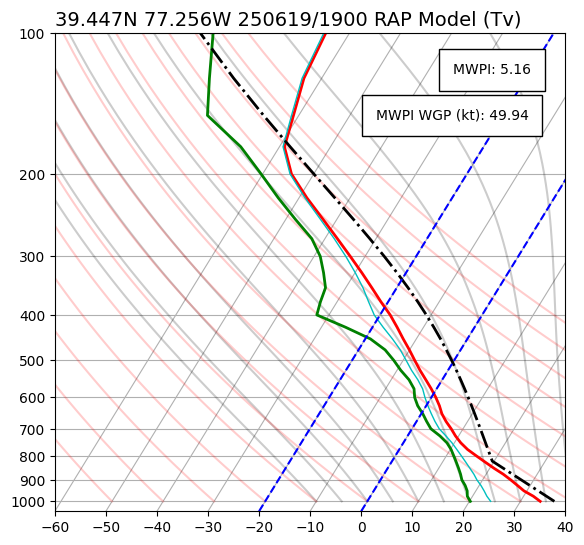

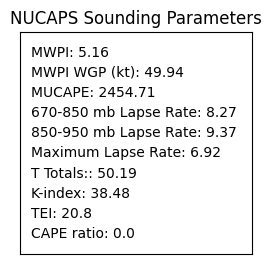

In [5]:
# Create a new figure. Plot a sounding emagram. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('39.447N 77.256W 250619/1900 RAP Model (Tv)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.tmpc, prof.pres, 'r', lw=2)
ax.semilogy(prof.dwpc, prof.pres, 'g', lw=2)
ax.semilogy(prof.wetbulb, prof.pres, 'c-', lw=1)

# Plot the parcel trace.
ax.semilogy(pcl.ttrace, pcl.ptrace, 'k-.', lw=2)

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-60,40)
xticks = np.arange(-60, 41, 10)
ax.set_xticks(xticks)

ax.text(-20, 120, r'MWPI: '+mwp_str, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
ax.text(-15, 150, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
# Show the plot to the user.
plt.savefig('skewt_rap_0619_1900_Tv.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
ax.set_title('NUCAPS Sounding Parameters')
#ax.set_xlabel('xlabel')
#ax.set_ylabel('ylabel')

# Set both x- and y-axis limits to [0, 10] instead of default [0, 1]
ax.axis([0, 10, 0, 11])
ax.text(0.5, 10, r'MWPI: '+mwp_str, size=10, ha='left', va='center')
ax.text(0.5, 9, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='left', va='center')
ax.text(0.5, 8, r'MUCAPE: '+mucape, size=10, ha='left', va='center')
ax.text(0.5, 7, r'670-850 mb Lapse Rate: '+lr_hi, size=10, ha='left', va='center')
ax.text(0.5, 6, r'850-950 mb Lapse Rate: '+lr_lo, size=10, ha='left', va='center')
ax.text(0.5, 5, r'Maximum Lapse Rate: '+lr_max, size=10, ha='left', va='center')
ax.text(0.5, 4, r'T Totals:: '+t_tot, size=10, ha='left', va='center')
ax.text(0.5, 3, r'K-index: '+k_idx, size=10, ha='left', va='center')
ax.text(0.5, 2, r'TEI: '+te_idx, size=10, ha='left', va='center')
ax.text(0.5, 1, r'CAPE ratio: '+caperat, size=10, ha='left', va='center')
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('skewt_rap_0619_1900_param_Tv.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

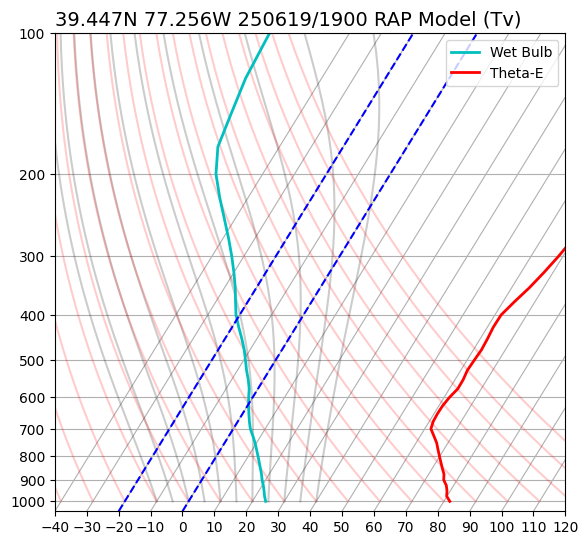

In [6]:
# Create a new figure. Plot a sounding emagram. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,150,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('39.447N 77.256W 250619/1900 RAP Model (Tv)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.wetbulb, prof.pres, 'c', lw=2, label='Wet Bulb')
ax.semilogy(thermo.ktoc(prof.thetae), prof.pres, 'r', lw=2, label='Theta-E')

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-40,120)
xticks = np.arange(-40, 121, 10)
ax.set_xticks(xticks)

# Show the plot to the user.
plt.legend()
plt.savefig('skewt_rap_0619_1900_wbte_Tv.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

In [14]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from six import StringIO
from six import BytesIO
import pandas as pd

'''
IAD Sterling RAOB Profile at 2025-06-19 1800 UTC
'''

nucaps_prof = "RAW_72403_2025-06-19_1800_sharp_txt.txt"
prof_data = np.loadtxt(nucaps_prof, usecols=range(0, 6), unpack=True)
print(prof_data)
pressure_mb = prof_data[0,:]
print(pressure_mb)
height_m = prof_data[1,:]
print(height_m)
temperature_c = prof_data[2,:]
print(temperature_c)
dewpoint_c = prof_data[3,:]
print(dewpoint_c)
wdir = prof_data[4,:]
print(wdir)
wspd = prof_data[5,:]
print(wspd)
height_km = height_m * .001
print(height_km,len(height_km))
RH = 100*(np.exp((17.625*dewpoint_c)/(243.04+dewpoint_c))/np.exp((17.625*temperature_c)/(243.04+temperature_c)))
print("RH: ", RH)
L_vapor = 2500
thetae = (273.15 + temperature_c)*((1000/pressure_mb)**0.286)+(3 * (RH * (3.884266 * 10**
         ((7.5 * temperature_c)/(237.7 + temperature_c)))/100))
wetbulb = temperature_c*(np.arctan(0.151977*((RH+8.313659)**0.5))) + (np.arctan(temperature_c+RH)) - (np.arctan(RH-1.676331))+((0.00391838*(RH**1.5))*(np.arctan(0.023101*RH))) - 4.686035
WBD = temperature_c - wetbulb
satmixrat = (6.11*(10**((7.5*temperature_c)/(237.7+temperature_c))))/1000
print("Sat_mix_ratio = ",satmixrat)
mixrat = (6.11*(10**((7.5*dewpoint_c)/(237.7+dewpoint_c))))/1000
print("Mix_ratio = ",mixrat)
thetaw = thetae - (L_vapor*mixrat)
temperature_k = temperature_c + 273.15
tempvirt = temperature_k*(1+(0.61*(mixrat)))
tempvirt_c = tempvirt - 273.15
print("Virtual Temperature (C) = ",tempvirt_c)
tempvirt_exc = tempvirt_c - temperature_c

idx_pup = np.where(pressure_mb == 799.9)
idx_plo = np.where(pressure_mb == 999.8)
print("PUP idx = ", idx_pup)
print("PLO idx = ", idx_plo)
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_sfc = temperature_k[idx_plo]
T_top = temperature_k[idx_pup]
Te_sfc = thetae[idx_plo]
Te_top = thetae[idx_pup]
Tv_sfc = tempvirt_c[idx_plo]
Tv_top = tempvirt_c[idx_pup]
wetbulb_sfc = wetbulb[idx_plo]
wetbulb_top = wetbulb[idx_pup]
thetaw_sfc = thetaw[idx_pup]
delta_z = 1189
delta_zkm = 1.189
gamma = (T_sfc - T_top)/(delta_zkm)
gamma_Te = (Te_sfc - Te_top)/(Z_lower - Z_upper)
gamma_Tv = (Tv_sfc - Tv_top)/(delta_zkm)
gamma_wb = (wetbulb_sfc - wetbulb_top)/(delta_zkm)

print("")
print("Gamma = ", gamma)
if gamma > 4.8 and gamma <= 9.8:
    print("Conditional Instability") 
elif gamma > 9.8:
    print("Absolute Instability")
print("Theta-e Gamma = ", gamma_Te)
if gamma_Te < 0:
    print("Theta-e lapse rate is negative: potential instability")    
print("Tv Gamma = ", gamma_Tv)
print("Wetbulb Gamma = ", gamma_wb)
if gamma_wb > 4.8:
    print("Potential Instability")    

P_level_upper = pressure_mb[idx_pup]
P_level_lower = pressure_mb[idx_plo]
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_upper = temperature_c[idx_pup]
T_lower = temperature_c[idx_plo]
Tv_upper = tempvirt_c[idx_pup]
Tv_lower = tempvirt_c[idx_plo]
TD_upper = dewpoint_c[idx_pup]
TD_lower = dewpoint_c[idx_plo]
CAPE = 289
 
def MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE):
        gamma = (T_lower - T_upper)/(Z_upper - Z_lower)
        DD_upper = T_upper - TD_upper
        DD_lower = T_lower - TD_lower
        DDD = DD_lower - DD_upper
        MWPI = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP = (0.35435365777 * (MWPI**2)) + (1.2959855*MWPI) + 33.8176788
        return MWPI, WGP    
MWPI, WGP  = MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI = ", MWPI)
print("MWPI WGP (kt) = ", WGP)

def MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE):
        gamma = (Tv_lower - Tv_upper)/(Z_upper - Z_lower)
        DD_upper = Tv_upper - TD_upper
        DD_lower = Tv_lower - TD_lower
        DDD = DD_lower - DD_upper
        MWPI_Tv = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP_Tv = (0.35435365777 * (MWPI_Tv**2)) + (1.2959855*MWPI_Tv) + 33.8176788
        return MWPI_Tv, WGP_Tv
MWPI_Tv, WGP_Tv  = MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI from Virtual Temperature:")
print("MWPI = ", MWPI_Tv)
print("MWPI WGP (kt) = ", WGP_Tv)

mydata=dict(zip(('hght','pres','temp','dwpt','thtae','thetaw','wetbulb','depression','tempvirt','tempvirt_exc'),(height_m,pressure_mb,temperature_c,dewpoint_c,thetae,thetaw,wetbulb,WBD,tempvirt_c,tempvirt_exc)))
print(mydata)
df_ret = pd.DataFrame.from_dict(mydata)
print(df_ret)
print("wdir, wspd: ", wdir, wspd)
data_sharppy=dict(zip(('pres','hght','temp','dwpt'),(pressure_mb, height_m, temperature_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'temp', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "temp": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")
print("Sounding profile with virtual temperature")
print("")
data_sharppy=dict(zip(('pres','hght','tempvirt','dwpt'),(pressure_mb, height_m, tempvirt_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'tempvirt', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "tempvirt": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")

[[ 9.9980e+02  9.9910e+02  9.9840e+02 ...  6.6000e+00  6.5000e+00
   6.4000e+00]
 [ 8.8000e+01  9.2000e+01  9.5000e+01 ...  3.4282e+04  3.4392e+04
   3.4498e+04]
 [ 3.1800e+01  3.1700e+01  3.1600e+01 ... -2.8300e+01 -2.8700e+01
  -2.9000e+01]
 [ 2.2300e+01  2.2100e+01  2.1900e+01 ... -7.3700e+01 -7.4000e+01
  -7.4200e+01]
 [ 2.2300e+02  2.2200e+02  2.2000e+02 ...  9.3000e+01  9.3000e+01
   9.4000e+01]
 [ 8.9000e+00  9.1000e+00  9.3000e+00 ...  3.8500e+01  3.4400e+01
   3.2500e+01]]
[999.8 999.1 998.4 ...   6.6   6.5   6.4]
[   88.    92.    95. ... 34282. 34392. 34498.]
[ 31.8  31.7  31.6 ... -28.3 -28.7 -29. ]
[ 22.3  22.1  21.9 ... -73.7 -74.  -74.2]
[223. 222. 220. ...  93.  93.  94.]
[ 8.9  9.1  9.3 ... 38.5 34.4 32.5]
[ 0.088  0.092  0.095 ... 34.282 34.392 34.498] 4834
RH:  [57.23426063 56.86318155 56.49370309 ...  0.47577252  0.47213887
  0.4711926 ]
Sat_mix_ratio =  [0.04688278 0.04661846 0.04635543 ... 0.00059215 0.00057034 0.00055447]
Mix_ratio =  [2.68726466e-02 2.65480100e-

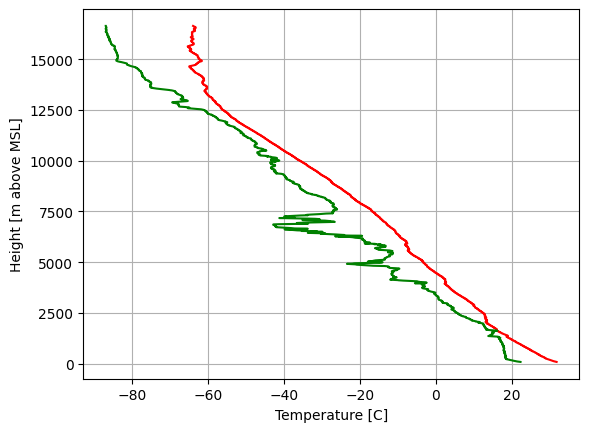

SURFACE HEIGHT (m MSL): 88.0
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 88.0


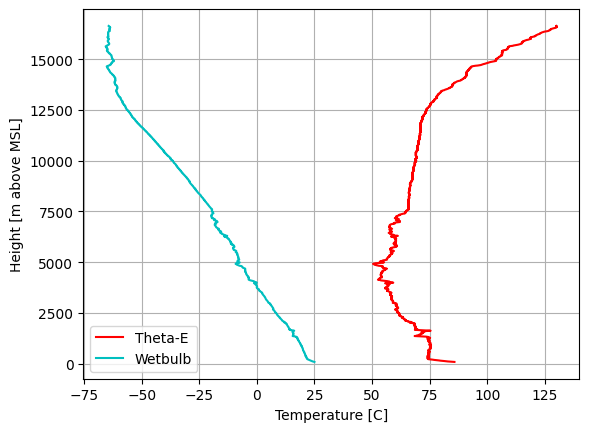

/data/home004/ken.pryor/.conda/envs/devel/lib/python3.9/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


Most-Unstable CAPE: 3918.86
Surface-based CAPE: 3918.86
Most-Unstable LCL: 1211.504134341448
Most-Unstable LFC: 1211.504134341448
Most-Unstable EL: 13829.0
Most-Unstable LI: -9.33
670-850 mb Lapse Rate: 6.73
850-950 mb Lapse Rate: 9.61
Maximum Lapse Rate: 6.73
MWPI: 7.06
T Totals: 48.3
K-index: 33.0
TEI: 33.2
MWPI WGP (kt): 60.63
SB CAPE =  3918.862279807341
MU CAPE =  3918.862279807341
CAPE Ratio =  0.0
Surface-based convection


In [1]:
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

spc_file = open('RAOB_72403_0619_1800_ret.txt', 'r').read()

import numpy as np
from io import StringIO

def parseSPC(spc_file):
    """
        This function will read a SPC-style formatted observed sounding file,
        similar to that of the 14061619.OAX file included in the SHARPpy distribution.

        It will return the pressure, height, temperature, dewpoint, wind direction and wind speed data
        from that file.
    """
    ## read in the file
    data = np.array([l.strip() for l in spc_file.split('\n')])

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0] + 1
    finish_idx = np.where( data == '%END%')[0]

    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx[0] : finish_idx[0]][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )

    return p, h, T, Td, wdir, wspd

pres, hght, tmpc, dwpc, wdir, wspd = parseSPC(spc_file)

prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, wspd=wspd, wdir=wdir, missing=-9999, strictQC=True)

import matplotlib.pyplot as plt
plt.plot(prof.tmpc, prof.hght, 'r-')
plt.plot(prof.dwpc, prof.hght, 'g-')
#plt.barbs(40*np.ones(len(prof.hght)), prof.hght, prof.u, prof.v)
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.grid()
plt.show()

msl_hght = prof.hght[prof.sfc] # Grab the surface height value
print("SURFACE HEIGHT (m MSL):",msl_hght)
agl_hght = interp.to_agl(prof, msl_hght) # Converts to AGL
print("SURFACE HEIGHT (m AGL):", agl_hght)
msl_hght = interp.to_msl(prof, agl_hght) # Converts to MSL
print("SURFACE HEIGHT (m MSL):",msl_hght)

plt.plot(thermo.ktoc(prof.thetae), prof.hght, 'r-', label='Theta-E')
plt.plot(prof.wetbulb, prof.hght, 'c-', label='Wetbulb')
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.legend()
plt.grid()
plt.show()

def lapse_rate(prof, lower, upper, pres=True):
    '''
        Calculates the lapse rate (C/km) from a profile object

        Parameters
        ----------
        prof : profile object
            Profile Object
        lower : number
            Lower Bound of lapse rate (mb or m AGL)
        upper : number
            Upper Bound of lapse rate (mb or m AGL)
        pres : bool (optional; default = True)
            Flag to determine if lower/upper are pressure [True]
            or height [False]

        Returns
        -------
        lapse rate (C/km) : number
        '''
    if pres:
        if (prof.pres[-1] > upper): return ma.masked
        p1 = lower
        p2 = upper
        z1 = interp.hght(prof, lower)
        z2 = interp.hght(prof, upper)
    else:
        z1 = interp.to_msl(prof, lower)
        z2 = interp.to_msl(prof, upper)
        p1 = interp.pres(prof, z1)
        p2 = interp.pres(prof, z2)
    tv1 = interp.vtmp(prof, p1)
    tv2 = interp.vtmp(prof, p2)
    return (tv2 - tv1) / (z2 - z1) * -1000.

def max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000):
    '''
        Calculates the maximum lapse rate (C/km) between a layer at a specified interval

        Parameters
        ----------
        prof: profile object
            Profile object
        lower : number
            Lower bound in height (m)
        upper : number
            Upper bound in height (m)
        interval : number
            Interval to assess the lapse rate at (m)
        depth : number
            Depth of the layer to assess the lapse rate over (m)

        Returns
        -------
        max lapse rate (C/km) : float
        lower pressure of max lapse rate (mb) : number
        upper pressure of max lapse rate (mb) : number
    '''

    bottom_levels = interp.to_msl(prof, np.arange(lower, upper-depth+interval, interval))
    top_levels = interp.to_msl(prof, np.arange(lower+depth, upper+interval, interval))
    bottom_pres = interp.pres(prof, bottom_levels)
    top_pres = interp.pres(prof, top_levels)
    all_lapse_rates = (interp.vtmp(prof, top_pres) - interp.vtmp(prof, bottom_pres)) * -1000.
    max_lapse_rate_idx = np.ma.argmax(all_lapse_rates)
    return all_lapse_rates[max_lapse_rate_idx]/depth, bottom_pres[max_lapse_rate_idx], top_pres[max_lapse_rate_idx]

def mwpi(prof):
    '''
        Microburst Windspeed Potential Index (MWPI)

        Formulated by Kenneth Pryor NOAA/NESDIS/STAR
        
        The Microburst Windspeed Potential Index (MWPI) is designed to quantify the most relevant factors
        in convective downburst generation in intermediate thermodynamic environments by incorporating 1) surface-based
        CAPE, 2) the temperature lapse rate between the 670- and 850-mb levels, and 3) DDD between the 670- and
        850-mb levels. The MWPI formula consists of a set of predictor variables (i.e., dewpoint depression
        and temperature lapse rate) that generates output of the expected microburst risk. 
        Scaling factors of 1000 J/kg, 5 C/km, and 5 C, respectively, are applied to the MWPI algorithm
        to yield a unitless MWPI value that expresses wind gust potential on a scale from 1 to 5:

        MWPI = (CAPE/1000) + LR/5 + DDD/5 
        
        Reference:
        Pryor, K. L., 2015: Progress and Developments of Downburst Prediction Applications of GOES. Wea. Forecasting, 30, 1182–1200.
        
        Parameters
        ----------
        prof : Profile object

        Returns
        -------
        mwpi : number
            MWPI (unitless)
    '''
    sbpcl = getattr(prof, 'sfcpcl', params.parcelx(prof, flag=1))
    sb_cape = sbpcl.bplus
    
    mupcl = getattr(prof, 'mupcl', params.parcelx(prof, flag=1))
    mu_cape = mupcl.bplus
    lr_hi = lapse_rate(prof, 850, 670, pres=True)
    lr_lo = lapse_rate(prof, 950, 850, pres=True)
    sfc = prof.pres[prof.sfc]
    
    if lr_hi > lr_lo:
    #MWPI calculation for 670-850 mb layer
        lr850_670 = lapse_rate(prof, 850, 670, pres=True)
        t670 = interp.temp(prof, 670.)
        t850 = interp.temp(prof, 850.)
        td670 = interp.dwpt(prof, 670.)
        td850 = interp.dwpt(prof, 850.)
        dd670 = t670 - td670
        dd850 = t850 - td850
        ddd = dd850 - dd670
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr850_670/5) + (ddd/5)
    elif sfc < 950:
    #MWPI calculation for 670-850 mb layer
        lr850_670 = lapse_rate(prof, 850, 670, pres=True)
        t670 = interp.temp(prof, 670.)
        t850 = interp.temp(prof, 850.)
        td670 = interp.dwpt(prof, 670.)
        td850 = interp.dwpt(prof, 850.)
        dd670 = t670 - td670
        dd850 = t850 - td850
        ddd = dd850 - dd670
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr850_670/5) + (ddd/5)    
    else:
    #MWPI calculation for surface-based mixed layer
        lr950_850 = lapse_rate(prof, 950, 850, pres=True)
        t850 = interp.temp(prof, 850.)
        t950 = interp.temp(prof, 950.)
        td850 = interp.dwpt(prof, 850.)
        td950 = interp.dwpt(prof, 950.)
        dd850 = t850 - td850
        dd950 = t950 - td950
        ddd = dd950 - dd850
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr950_850/5) + (ddd/5)
    
    return mwpi

sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel
mu_cape = mupcl.bplus
mucape = str(round(mupcl.bplus,2))
print("Most-Unstable CAPE:", mucape) # J/kg
sb_cape = sfcpcl.bplus
sbcape = str(round(sfcpcl.bplus,2))
print("Surface-based CAPE:", sbcape) # J/kg
lcl = mupcl.lclhght
lfc = mupcl.lfchght
el = str(round(mupcl.elhght,2))
li = str(round(mupcl.li5,2))
print("Most-Unstable LCL:", lcl) # meters AGL
print("Most-Unstable LFC:", lfc) # meters AGL
print("Most-Unstable EL:", el) # meters AGL
print("Most-Unstable LI:", li) # C
lr_hi = str(round(lapse_rate(prof, 850, 670, pres=True),2))
print("670-850 mb Lapse Rate:", lr_hi)
lr_lo = str(round(lapse_rate(prof, 950, 850, pres=True),2))
print("850-950 mb Lapse Rate:", lr_lo)
lapse_rate_max, bottom_pres, top_pres = max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000)
lr_max = str(round(lapse_rate_max,2))
print("Maximum Lapse Rate:", lr_max)
mwp = round(mwpi(prof),2)
mwp_str = str(mwp)
print("MWPI:", mwp_str) 
t_tot = str(round(params.t_totals(prof),2))
print("T Totals:", t_tot)
k_idx = str(round(params.k_index(prof),2))
print("K-index:", k_idx)
te_idx = str(round(params.tei(prof),2))
print("TEI:", te_idx)
#WGP = (0.35435365777 * ((params.mwpi(prof))**2)) + (1.2959855*(params.mwpi(prof))) + 33.8176788
WGP = (0.35435365777 * (mwp**2)) + (1.2959855*mwp) + 33.8176788
mwpi_gp = str(round(WGP,2))
print("MWPI WGP (kt):", mwpi_gp)

#Calculate CAPE ratio
cape_ratio = 1 - ((sb_cape/mu_cape))
caperat = str(round(cape_ratio,2))
print("SB CAPE = ", sb_cape)
print("MU CAPE = ", mu_cape)
print("CAPE Ratio = ", caperat)
if cape_ratio > 0.3 and cape_ratio < 0.7:
    print("Hybrid Surface-based/elevated convection") 
elif cape_ratio >= 0.7:
    print("Elevated convection")
else:
    print("Surface-based convection") 

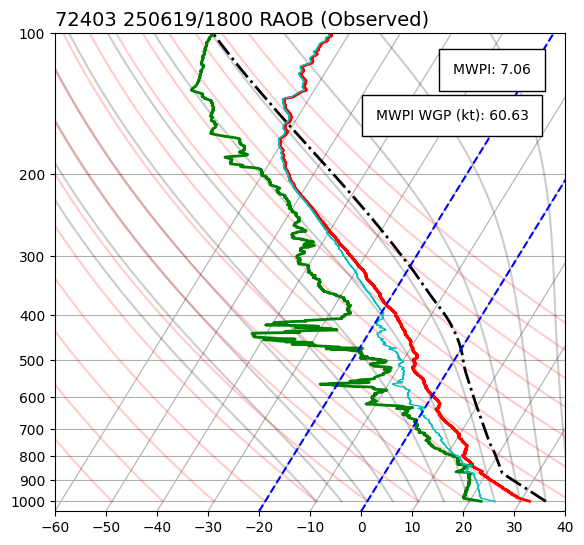

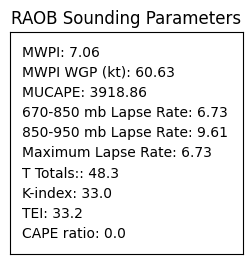

In [2]:
# Create a new figure. Plot a sounding emagram. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('72403 250619/1800 RAOB (Observed)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.tmpc, prof.pres, 'r', lw=2)
ax.semilogy(prof.dwpc, prof.pres, 'g', lw=2)
ax.semilogy(prof.wetbulb, prof.pres, 'c-', lw=1)

# Plot the parcel trace.
ax.semilogy(pcl.ttrace, pcl.ptrace, 'k-.', lw=2)

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-60,40)
xticks = np.arange(-60, 41, 10)
ax.set_xticks(xticks)

ax.text(-20, 120, r'MWPI: '+mwp_str, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
ax.text(-15, 150, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
# Show the plot to the user.
plt.savefig('raob_72403_0619_1800.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
ax.set_title('RAOB Sounding Parameters')
#ax.set_xlabel('xlabel')
#ax.set_ylabel('ylabel')

# Set both x- and y-axis limits to [0, 10] instead of default [0, 1]
ax.axis([0, 10, 0, 11])
ax.text(0.5, 10, r'MWPI: '+mwp_str, size=10, ha='left', va='center')
ax.text(0.5, 9, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='left', va='center')
ax.text(0.5, 8, r'MUCAPE: '+mucape, size=10, ha='left', va='center')
ax.text(0.5, 7, r'670-850 mb Lapse Rate: '+lr_hi, size=10, ha='left', va='center')
ax.text(0.5, 6, r'850-950 mb Lapse Rate: '+lr_lo, size=10, ha='left', va='center')
ax.text(0.5, 5, r'Maximum Lapse Rate: '+lr_max, size=10, ha='left', va='center')
ax.text(0.5, 4, r'T Totals:: '+t_tot, size=10, ha='left', va='center')
ax.text(0.5, 3, r'K-index: '+k_idx, size=10, ha='left', va='center')
ax.text(0.5, 2, r'TEI: '+te_idx, size=10, ha='left', va='center')
ax.text(0.5, 1, r'CAPE ratio: '+caperat, size=10, ha='left', va='center')
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('raob_72403_0619_1800_param.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

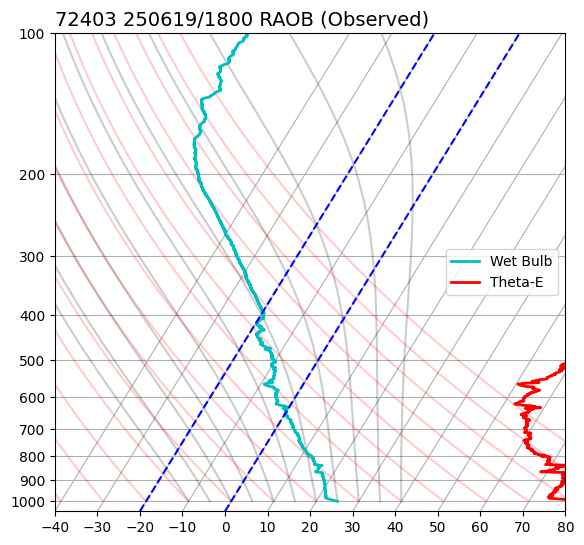

In [3]:
# Create a new figure. Plot a sounding emagram. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('72403 250619/1800 RAOB (Observed)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.wetbulb, prof.pres, 'c', lw=2, label='Wet Bulb')
ax.semilogy(thermo.ktoc(prof.thetae), prof.pres, 'r', lw=2, label='Theta-E')

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-40,80)
xticks = np.arange(-40, 81, 10)
ax.set_xticks(xticks)

# Show the plot to the user.
plt.legend()
plt.savefig('raob_72403_0619_1800_wbte.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

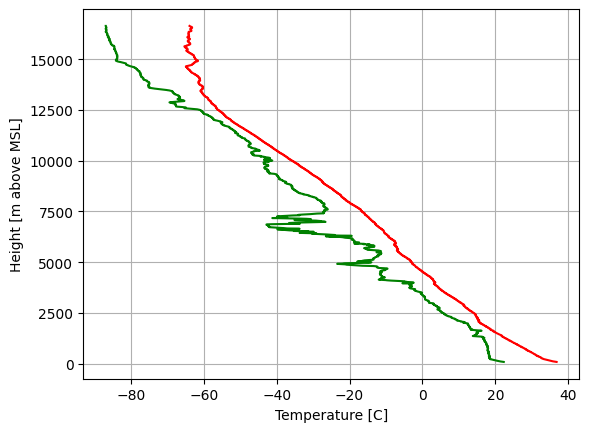

SURFACE HEIGHT (m MSL): 88.0
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 88.0


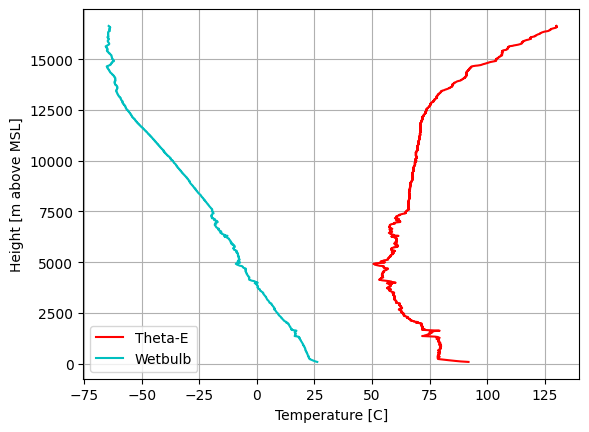

Most-Unstable CAPE: 5840.05
Surface-based CAPE: 5840.05
Most-Unstable LCL: 1812.75
Most-Unstable LFC: 1812.7518493433495
Most-Unstable EL: 14846.0
Most-Unstable LI: -11.54
670-850 mb Lapse Rate: 7.75
850-950 mb Lapse Rate: 10.38
Maximum Lapse Rate: 7.29
MWPI: 9.28
T Totals: 50.64
K-index: 34.57
TEI: 38.84
MWPI WGP (kt): 76.36
SB CAPE =  5840.054987045938
MU CAPE =  5840.054987045938
CAPE Ratio =  0.0
Surface-based convection


In [4]:
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

spc_file = open('RAOB_72403_0619_1800_Tv_ret.txt', 'r').read()

import numpy as np
from io import StringIO

def parseSPC(spc_file):
    """
        This function will read a SPC-style formatted observed sounding file,
        similar to that of the 14061619.OAX file included in the SHARPpy distribution.

        It will return the pressure, height, temperature, dewpoint, wind direction and wind speed data
        from that file.
    """
    ## read in the file
    data = np.array([l.strip() for l in spc_file.split('\n')])

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0] + 1
    finish_idx = np.where( data == '%END%')[0]

    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx[0] : finish_idx[0]][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )

    return p, h, T, Td, wdir, wspd

pres, hght, tmpc, dwpc, wdir, wspd = parseSPC(spc_file)

prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, wspd=wspd, wdir=wdir, missing=-9999, strictQC=True)

import matplotlib.pyplot as plt
plt.plot(prof.tmpc, prof.hght, 'r-')
plt.plot(prof.dwpc, prof.hght, 'g-')
#plt.barbs(40*np.ones(len(prof.hght)), prof.hght, prof.u, prof.v)
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.grid()
plt.show()

msl_hght = prof.hght[prof.sfc] # Grab the surface height value
print("SURFACE HEIGHT (m MSL):",msl_hght)
agl_hght = interp.to_agl(prof, msl_hght) # Converts to AGL
print("SURFACE HEIGHT (m AGL):", agl_hght)
msl_hght = interp.to_msl(prof, agl_hght) # Converts to MSL
print("SURFACE HEIGHT (m MSL):",msl_hght)

plt.plot(thermo.ktoc(prof.thetae), prof.hght, 'r-', label='Theta-E')
plt.plot(prof.wetbulb, prof.hght, 'c-', label='Wetbulb')
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.legend()
plt.grid()
plt.show()

def lapse_rate(prof, lower, upper, pres=True):
    '''
        Calculates the lapse rate (C/km) from a profile object

        Parameters
        ----------
        prof : profile object
            Profile Object
        lower : number
            Lower Bound of lapse rate (mb or m AGL)
        upper : number
            Upper Bound of lapse rate (mb or m AGL)
        pres : bool (optional; default = True)
            Flag to determine if lower/upper are pressure [True]
            or height [False]

        Returns
        -------
        lapse rate (C/km) : number
        '''
    if pres:
        if (prof.pres[-1] > upper): return ma.masked
        p1 = lower
        p2 = upper
        z1 = interp.hght(prof, lower)
        z2 = interp.hght(prof, upper)
    else:
        z1 = interp.to_msl(prof, lower)
        z2 = interp.to_msl(prof, upper)
        p1 = interp.pres(prof, z1)
        p2 = interp.pres(prof, z2)
    tv1 = interp.vtmp(prof, p1)
    tv2 = interp.vtmp(prof, p2)
    return (tv2 - tv1) / (z2 - z1) * -1000.

def max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000):
    '''
        Calculates the maximum lapse rate (C/km) between a layer at a specified interval

        Parameters
        ----------
        prof: profile object
            Profile object
        lower : number
            Lower bound in height (m)
        upper : number
            Upper bound in height (m)
        interval : number
            Interval to assess the lapse rate at (m)
        depth : number
            Depth of the layer to assess the lapse rate over (m)

        Returns
        -------
        max lapse rate (C/km) : float
        lower pressure of max lapse rate (mb) : number
        upper pressure of max lapse rate (mb) : number
    '''

    bottom_levels = interp.to_msl(prof, np.arange(lower, upper-depth+interval, interval))
    top_levels = interp.to_msl(prof, np.arange(lower+depth, upper+interval, interval))
    bottom_pres = interp.pres(prof, bottom_levels)
    top_pres = interp.pres(prof, top_levels)
    all_lapse_rates = (interp.vtmp(prof, top_pres) - interp.vtmp(prof, bottom_pres)) * -1000.
    max_lapse_rate_idx = np.ma.argmax(all_lapse_rates)
    return all_lapse_rates[max_lapse_rate_idx]/depth, bottom_pres[max_lapse_rate_idx], top_pres[max_lapse_rate_idx]

def mwpi(prof):
    '''
        Microburst Windspeed Potential Index (MWPI)

        Formulated by Kenneth Pryor NOAA/NESDIS/STAR
        
        The Microburst Windspeed Potential Index (MWPI) is designed to quantify the most relevant factors
        in convective downburst generation in intermediate thermodynamic environments by incorporating 1) surface-based
        CAPE, 2) the temperature lapse rate between the 670- and 850-mb levels, and 3) DDD between the 670- and
        850-mb levels. The MWPI formula consists of a set of predictor variables (i.e., dewpoint depression
        and temperature lapse rate) that generates output of the expected microburst risk. 
        Scaling factors of 1000 J/kg, 5 C/km, and 5 C, respectively, are applied to the MWPI algorithm
        to yield a unitless MWPI value that expresses wind gust potential on a scale from 1 to 5:

        MWPI = (CAPE/1000) + LR/5 + DDD/5 
        
        Reference:
        Pryor, K. L., 2015: Progress and Developments of Downburst Prediction Applications of GOES. Wea. Forecasting, 30, 1182–1200.
        
        Parameters
        ----------
        prof : Profile object

        Returns
        -------
        mwpi : number
            MWPI (unitless)
    '''
    sbpcl = getattr(prof, 'sfcpcl', params.parcelx(prof, flag=1))
    sb_cape = sbpcl.bplus
    
    mupcl = getattr(prof, 'mupcl', params.parcelx(prof, flag=1))
    mu_cape = mupcl.bplus
    lr_hi = lapse_rate(prof, 850, 670, pres=True)
    lr_lo = lapse_rate(prof, 950, 850, pres=True)
    sfc = prof.pres[prof.sfc]
    
    if lr_hi > lr_lo:
    #MWPI calculation for 670-850 mb layer
        lr850_670 = lapse_rate(prof, 850, 670, pres=True)
        t670 = interp.temp(prof, 670.)
        t850 = interp.temp(prof, 850.)
        td670 = interp.dwpt(prof, 670.)
        td850 = interp.dwpt(prof, 850.)
        dd670 = t670 - td670
        dd850 = t850 - td850
        ddd = dd850 - dd670
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr850_670/5) + (ddd/5)
    elif sfc < 950:
    #MWPI calculation for 670-850 mb layer
        lr850_670 = lapse_rate(prof, 850, 670, pres=True)
        t670 = interp.temp(prof, 670.)
        t850 = interp.temp(prof, 850.)
        td670 = interp.dwpt(prof, 670.)
        td850 = interp.dwpt(prof, 850.)
        dd670 = t670 - td670
        dd850 = t850 - td850
        ddd = dd850 - dd670
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr850_670/5) + (ddd/5)    
    else:
    #MWPI calculation for surface-based mixed layer
        lr950_850 = lapse_rate(prof, 950, 850, pres=True)
        t850 = interp.temp(prof, 850.)
        t950 = interp.temp(prof, 950.)
        td850 = interp.dwpt(prof, 850.)
        td950 = interp.dwpt(prof, 950.)
        dd850 = t850 - td850
        dd950 = t950 - td950
        ddd = dd950 - dd850
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr950_850/5) + (ddd/5)
    
    return mwpi

sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel
mu_cape = mupcl.bplus
mucape = str(round(mupcl.bplus,2))
print("Most-Unstable CAPE:", mucape) # J/kg
sb_cape = sfcpcl.bplus
sbcape = str(round(sfcpcl.bplus,2))
print("Surface-based CAPE:", sbcape) # J/kg
lcl = round(mupcl.lclhght,2)
lfc = mupcl.lfchght
el = round(mupcl.elhght,2)
li = str(round(mupcl.li5,2))
print("Most-Unstable LCL:", lcl) # meters AGL
print("Most-Unstable LFC:", lfc) # meters AGL
print("Most-Unstable EL:", el) # meters AGL
print("Most-Unstable LI:", li) # C
lr_hi = str(round(lapse_rate(prof, 850, 670, pres=True),2))
print("670-850 mb Lapse Rate:", lr_hi)
lr_lo = str(round(lapse_rate(prof, 950, 850, pres=True),2))
print("850-950 mb Lapse Rate:", lr_lo)
lapse_rate_max, bottom_pres, top_pres = max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000)
lr_max = str(round(lapse_rate_max,2))
print("Maximum Lapse Rate:", lr_max)
mwp = round(mwpi(prof),2)
mwp_str = str(mwp)
print("MWPI:", mwp_str) 
t_tot = str(round(params.t_totals(prof),2))
print("T Totals:", t_tot)
k_idx = str(round(params.k_index(prof),2))
print("K-index:", k_idx)
te_idx = str(round(params.tei(prof),2))
print("TEI:", te_idx)
#WGP = (0.35435365777 * ((params.mwpi(prof))**2)) + (1.2959855*(params.mwpi(prof))) + 33.8176788
WGP = (0.35435365777 * (mwp**2)) + (1.2959855*mwp) + 33.8176788
mwpi_gp = str(round(WGP,2))
print("MWPI WGP (kt):", mwpi_gp)

#Calculate CAPE ratio
cape_ratio = 1 - ((sb_cape/mu_cape))
caperat = str(round(cape_ratio,2))
print("SB CAPE = ", sb_cape)
print("MU CAPE = ", mu_cape)
print("CAPE Ratio = ", caperat)
if cape_ratio > 0.3 and cape_ratio < 0.7:
    print("Hybrid Surface-based/elevated convection") 
elif cape_ratio >= 0.7:
    print("Elevated convection")
else:
    print("Surface-based convection")
 

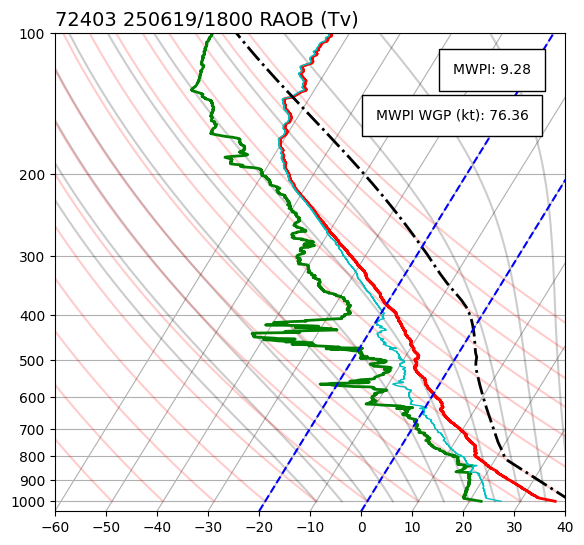

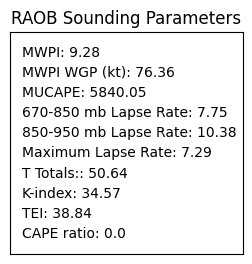

In [5]:
# Create a new figure. Plot a sounding emagram. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('72403 250619/1800 RAOB (Tv)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.tmpc, prof.pres, 'r', lw=2)
ax.semilogy(prof.dwpc, prof.pres, 'g', lw=2)
ax.semilogy(prof.wetbulb, prof.pres, 'c-', lw=1)

# Plot the parcel trace.
ax.semilogy(pcl.ttrace, pcl.ptrace, 'k-.', lw=2)

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-60,40)
xticks = np.arange(-60, 41, 10)
ax.set_xticks(xticks)

ax.text(-20, 120, r'MWPI: '+mwp_str, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
ax.text(-15, 150, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
# Show the plot to the user.
plt.savefig('raob_72403_0619_1800_Tv.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
ax.set_title('RAOB Sounding Parameters')
#ax.set_xlabel('xlabel')
#ax.set_ylabel('ylabel')

# Set both x- and y-axis limits to [0, 10] instead of default [0, 1]
ax.axis([0, 10, 0, 11])
ax.text(0.5, 10, r'MWPI: '+mwp_str, size=10, ha='left', va='center')
ax.text(0.5, 9, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='left', va='center')
ax.text(0.5, 8, r'MUCAPE: '+mucape, size=10, ha='left', va='center')
ax.text(0.5, 7, r'670-850 mb Lapse Rate: '+lr_hi, size=10, ha='left', va='center')
ax.text(0.5, 6, r'850-950 mb Lapse Rate: '+lr_lo, size=10, ha='left', va='center')
ax.text(0.5, 5, r'Maximum Lapse Rate: '+lr_max, size=10, ha='left', va='center')
ax.text(0.5, 4, r'T Totals:: '+t_tot, size=10, ha='left', va='center')
ax.text(0.5, 3, r'K-index: '+k_idx, size=10, ha='left', va='center')
ax.text(0.5, 2, r'TEI: '+te_idx, size=10, ha='left', va='center')
ax.text(0.5, 1, r'CAPE ratio: '+caperat, size=10, ha='left', va='center')
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('raob_72403_0619_1800_param_Tv.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

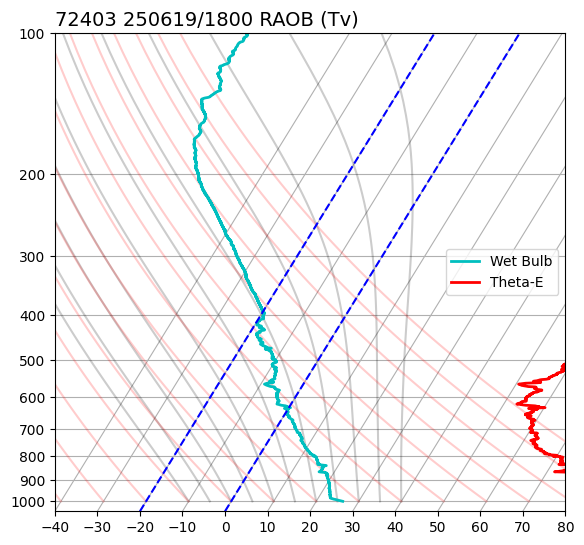

In [6]:
# Create a new figure. Plot a sounding emagram. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('72403 250619/1800 RAOB (Tv)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.wetbulb, prof.pres, 'c', lw=2, label='Wet Bulb')
ax.semilogy(thermo.ktoc(prof.thetae), prof.pres, 'r', lw=2, label='Theta-E')

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-40,80)
xticks = np.arange(-40, 81, 10)
ax.set_xticks(xticks)

# Show the plot to the user.
plt.legend()
plt.savefig('raob_72403_0619_1800_wbte_Tv.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()